## GDScript - explorace výkonových charakteristik

#### GDScript - představení

GDScript je skriptovací jazyk integrovaný v opensource herním enginu Godot.  

Ačkoliv je možné ho v určitém smyslu považovat za jazyk relativně exotický, s nulovou uživatelskou základnou mimo Godot, pro uživatele Godotu bývá často z mnoha důvodů první volbou pro programování herní logiky. Jmenovitě proto, že funguje out-of-the-box na všech platformách, které Godot podporuje (narozdíl např. od C#, který je ošemetný na mobilních platformách), má poměrně použitelný editor a debugger integrovaný přímo do UI enginu, a mnoho specifických Godotích fíčur (např. signály, strom herní scény, singletony) je v něm podporováno velmi ergonomicky skrz dedikované jazykové konstrukty.

Nejde o jazyk designovaný pro dosažení co nejvyššího runtime výkonu, mnohem prioritnější je schopnost rychlé iterace a experimentování nad herní logikou ( -> pokud možno schopnost hotreload, nulové čekání na kompilaci, graduální typování), stručnost implementace jazyka, a přístupnost i pro nezkušené programátory. Nicméně, jedním výkonovým problémem, proti kterému se GDScript odhodlal vymezit, jsou, pro hry velmi palčivé, příležitostné propady framerate v důsledku běhu GC. Na rozdíl od většiny typických skriptovacích jazyků (Python, Lua apod.) zde nalezneme bohatý výběr užitečných "primitivních" datových typů schopných alokace na stacku a plnohodnotný GC byl zcela zrušen výměnou za (uživateli explicitně komunikovaný) reference counting. Všeobecně je uživatel designem jazyka nenápadně popostrkován, aby si vystačil co nejvíce pouze s primitivními typy a Nody herní scény (ty mají explicitní lifetime) a na reference counting musel spoléhat zřídka.   

Vcelku by se dalo říci, že jde o jazyk kdesi na pomezí mezi general-purpose a DSL.   

Z hlediska organizace zdrojového kódu, veškerá implementace GDSkriptího interpreteru, editoru, debuggeru apod. je jedním z mnoha podmodulů herního enginu, její zdrojový kód lze přečíst [zde](https://github.com/godotengine/godot/tree/master/modules/gdscript).    

Implementací jde o poměrně přímočarý bytecode interpreter, který se nepokouší o mnoho optimalizací.

Jazyk je spolu s celým enginem aktivně vyvíjen, celý tento text se vztahuje pouze na implementaci přítomnou v Godotu 4.4 (v době psaní nejnovější stabilní verze).  

#### Cíl experimentu

Vzhledem k tomu, že je GDScript poměrně niche jazyk používaný pouze ve velmi specifické sociální bublině, není toho o výkonu jeho implementace všeobecně mnoho známo.   

Tento experiment se nepokouší o srovnání výkonu GDScriptu s jinými v Godotu zprovoznitelnými skriptovacími jazyky.   
Vycházíme ze situace, kdy je již (z mnoha dobrých důvodů zmíněných výše) uživatel rozhodnut, že GDScript použije, a pokládá si otázku, jak svou logiku psát, aby se zbytečně neokrádal o výkon, popř. jaké (i třeba strukturu kódu zhoršující) poučky lze vytáhnout z rukávu, optimalizujeme-li na dřeň nějakou kritickou smyčku. V případě, že objevíme situaci, kde nejvýkonnější postup je nevalně kompatibilní s dobrou štábní kulturou, zajímá nás jak velkou cenu za čistý kód platíme.     

S trochou štěstí v implementaci GDScriptu odhalíme nějaké výkonové deficity, které jsou snadno napravitelné bez nutnosti celou logiku interpreteru od základu překopat, a mohou později být proměněny v pull-request.   

Postupovat budeme tak, že v GDScriptu napíšeme sérii mikrobenchmarků - pro běžné každodenní operace (jako např. control flow, čtení/zápis z proměnné/property, práce s datovými strukturami) představíme různé metody jak je provádět, které GDScript nabízí, a vzájemně porovnáme kolik času zabere jejich běh a kolik příp. alokují paměti. Obdobně vytvoříme mikrobenchmarky pro otestování, zda a za jakých okolností GDScript provádí některé obvyklé triviální optimalizace (constant-folding, eliminace kódu bez sideefektů apod.). 

Naměřená data následně porovnáme s intuitivními očekáváními a nesrovnalosti se pokusíme prozkoumat více do hloubky a vysvětlit, např. prohlížením vygenerovaného bytekódu, prokrokováním vnitřností interpreteru v debuggeru, popř. do překladače nebo interpreteru připíšeme drobné kousky kódu navíc, jako méně systematický ekvivalent instrumentace.   
Celkově náš úkol do jisté míry využijeme jako příležitost, abychom se seznámili s Godotí codebase.    


High-level shrnutí našich předběžných očekávání ohledně výkonu GDScriptu:
 - nejlepší výkon při použití jako "lepidlo" mezi nativními funkcemi
 -  ̶d̶y̶n̶a̶m̶i̶c̶k̶ý̶ ̶v̶s̶ ̶t̶y̶p̶o̶v̶a̶n̶ý̶ ̶k̶ó̶d̶ ̶b̶u̶d̶e̶ ̶s̶t̶e̶j̶n̶ě̶ ̶p̶o̶m̶a̶l̶ý̶,̶ ̶t̶y̶p̶y̶ ̶s̶l̶o̶u̶ž̶í̶ ̶p̶o̶u̶z̶e̶ ̶k̶ ̶p̶r̶o̶g̶r̶a̶m̶á̶t̶o̶r̶s̶k̶é̶m̶u̶ ̶p̶o̶h̶o̶d̶l̶í (odvoláno po zběžném nahlédnutí na [seznam opcodů](https://github.com/godotengine/godot/blob/3c7f9b937214068bc892be0d2bd9a8a7026edae1/modules/gdscript/gdscript_function.h#L331))
 - čím silněji typovaný kód, tím rychlejší (největší rozdíl pokud operuje nad primitivními typy)
 - pokud se držíme standardně uznávaných zásad čistého OOP kódu, neměl by se náš výkon diametrálně odchýlit od optima

#### Testovací sestava

Veškerá naměřená data byla pořízena na stolním PC:
 - CPU: Intel Core Ultra 7 265K (8 x P-core + 12 x E-core), stock nastavení, chlazený vzduchem vždy pod 80°C
 - RAM: 2x16GB DDR5 6000MHz
 - OS: Windows 11 Pro 24H2
 - Godot: verze odpovídající obsahu branche `4.4` ke dni 27.8.2025, manuálně pořízený release build s vlastními úpravami (popsány dále)
 	- zdrojový kód forku lze nalézt v branchi [godot-fork](https://github.com/MarkusSecundus/NSWI131-Credit-GDScriptPerformanceEvaluation/tree/godot-fork)
	- benchmarkovací projekt lze nalézt v branchi [benchmarks](https://github.com/MarkusSecundus/NSWI131-Credit-GDScriptPerformanceEvaluation/tree/benchmarks)

#### Jak benchmarkovat GDScript

Forma mikrobenchmarků si v průběhu experimentu prošla několika iteracemi, zde popíšeme finální verzi ke které jsme došli:   

**Každý microbenchmark je definován třídou dědící z `IBenchmark`.**    
Implementuje funkce: 
 - `run_benchmark(repetitions_count: int, param_opt)->int`...
	- sama zodpovědná za pořízení timestampu na začátku a na konci, a za to, aby se payload provedl `repetitions_count`-krát
	- vrací čas v mikrosekundách, který zabralo provedení payloadu `repetitions_count`-krát (nejjemnější časovač, který Godot nabízí, je `Time.get_ticks_usec()` - [viz](https://gitlab.mff.cuni.cz/teaching/nswi131/2025/student-HRONIKJ/-/blob/master/task-01/01-timers/SOLUTION.ipynb?ref_type=heads) )
	- důvod: jak zjistíme, GDScript neprovádí inlinování funkcí ani v triviálních případech a volání funkce má overhead často několikanásobně větší než jedna instance našeho payloadu; rovněž se zde nekoná žádné inkrementální optimalizování funkcí na základě toho kolikrát byly volány  
	- v jiných jazycích typické akumulování dummy mezivýsledku, který pak vracíme z funkce, aby se zabránilo odoptimalizování payloadu pryč, zde není třeba - jak zjistíme, GDScript je schopen odoptimalizovávat kód pryč pouze ve velmi specifickém případě výrazů, které se plně zconstant-foldují
		- v některých microbenchmarcích budeme akumulaci mezivýsledků stále vykonávat, abychom zasadili použití payloadu do minimálního kontextu ve kterém dává smysl (např. sčítání dvou čísel nedává v praxi smysl pokud výsledek zahodíme a nikam ho neuložíme)
	- typický tvar funkce:
		```py
		func run_benchmark(repetitions: int, _param: Variant)->int:
			var param : some_type = _param  # optional 
			var start_time :int = Time.get_ticks_usec()
			for repetition in repetitions: # fastest way to iterate over <0;repetitions), no dynamic allocation
				# payload
			return Time.get_ticks_usec() - start_time
		```
 - `get_params()->Array` (volitelně)... 
	- vrací pole hodnot, benchmark se vykoná pro každou z hodnot
	- _jak později zjistíme, interakce s typovanou lokální proměnnou je zhruba stejně rychlá jako s konstantou_
 -  ve všech případech, kdy jsme k benchmarku potřebovali vykonávat přípravnou práci (alokace pomocných objektů nad kterými budeme operovat apod.), jsme si vystačili s konstruktorem, žádné metody `prepare()`, `cleanup()` apod. nebyly třeba

**Benchmarkovací framework...**
 - iteruje přes všechny benchmarky, pro každý benchmark:
	- vytvoří instanci jeho třídy (zavolá konstruktor který příp. vykoná přípravné operace)
	- pokud benchmark definuje `get_params()`, iteruje přes všechny parametry
	- nejprve zavolá `run_benchmark()` jednou na warmup
	- pak ho zavolá znovu už doopravdy, tentokrát se zapnutým trackováním dynamických alokací (viz dále)
	- **počet repeticí:** `10_000` pro warmup, `50_000` pro hlavní běh
	- vypíše naměřené výsledky do konzole (human readable forma) a volitelně do výstupního .csv souboru


**Provedená měření:**
 1. všechny benchmarky zopakovány 20-krát
 2. všechny benchmarky 20-krát, s warmupem `50_000`
 2. všechny benchmarky 20-krát, v převráceném pořadí
 3. všechny benchmarky 60-krát
 4. všechny benchmarky 20-krát znovu, tentokrát nezapomenuto vypnout E-jádra na CPU
 5. všechny benchmarky 232-krát na CPU Core i7 9700KF, 32GB DDR4 2400MHz, Windows 10

V další části budeme primárně pracovat s daty z běhů 1-5 konkatenovanými dohromady. Uvidíme, že mezi daty z různých běhů nejsou patrné větší rozdíly, z toho plyne, že:
 - `10_000` opakování je na warmup dostatečné
 - pořadí, ve kterém jsou benchmarky vykonávány, na jejich běh nemá vliv
 - Godot netrpí na memory leaky/fragmentaci haldy či podobné vlivy, které by jeho běh v průběhu času zpomalovaly
 - stejně tak nevykonává žádné profilovací optimalizace, které by v dlouhodobém horizontu zvyšovaly výkon programu čím déle běží
 - první 4 běhy pravděpodobně běžely korektně na P-jádru

Pro přepnutí grafu na i7 9700KF, změňte hodnotu na následující řádce:

In [3]:
CPU_CHOICE = "265K" # ("265K"|"9700KF"|"both")

In [69]:
# Define the format of measurements

import numpy as np
from matplotlib import pyplot as plt
from collections import defaultdict
from dataclasses import dataclass

ArithmeticBenchmarks = "ArithmeticBenchmarks"
IterationBenchmarks = "IterationBenchmarks"
FunctioncallBenchmarks = "FunctioncallBenchmarks"
DatastructBenchmarksLoad = "DatastructBenchmarksLoad"
DatastructBenchmarksLoadFixed = "DatastructBenchmarksLoadFixed"
DatastructBenchmarksStore = "DatastructBenchmarksStore"
DatastructBenchmarksCreation = "DatastructBenchmarksCreation"
ConversionBenchmarks = "ConversionBenchmarks"


@dataclass
class Measurement:
	usec : float
	allocs : float
	frees : float
	reallocs : float
	alloc_bytes : float
	free_bytes : float

	is_memory_leak: bool

def all_usecs(measurements: list[Measurement])->list[float]: return [x.usec for x in measurements]
def all_allocs(measurements: list[Measurement])->list[float]: return [x.allocs for x in measurements]
def all_frees(measurements: list[Measurement])->list[float]: return [x.frees for x in measurements]
def all_reallocs(measurements: list[Measurement])->list[float]: return [x.reallocs for x in measurements]
def all_alloc_bytes(measurements: list[Measurement])->list[float]: return [x.alloc_bytes for x in measurements]
def all_free_bytes(measurements: list[Measurement])->list[float]: return [x.free_bytes for x in measurements]
def all_is_memory_leak(measurements: list[Measurement])->list[bool]: return [x.is_memory_leak for x in measurements]


def load_measurements(path: str)->defaultdict:
	ret = defaultdict(dict)
	with open(path, "r") as f:
		for line_it in f:
			line :str = line_it
			fields = line.split(";")
			bench_section: str 	= fields[0]
			bench_name: str 	= fields[1]
			bench_param: str 	= fields[2]
			measured_usec_total = int(fields[3])
			repetitions_count	= int(fields[4])
			alloc_count_total	= int(fields[5])
			alloc_bytes_total	= int(fields[6])
			free_count_total	= int(fields[7])
			free_bytes_total	= int(fields[8])
			reallocs_count_total= int(fields[9])
			if not bench_name in ret[bench_section]:
				ret[bench_section][bench_name] = (defaultdict(list) if bench_param else list())
			bench_run = ret[bench_section][bench_name]
			if bench_param: bench_run = bench_run[bench_param]
			bench_run.append(Measurement(
				measured_usec_total / repetitions_count,
				alloc_count_total / repetitions_count,
				free_count_total / repetitions_count,
				reallocs_count_total / repetitions_count,
				alloc_bytes_total / repetitions_count,
				free_bytes_total / repetitions_count,
				(alloc_count_total != free_count_total)
			))

	return ret

def concat_measurements(a: defaultdict, b: defaultdict)->defaultdict:
	ret = defaultdict(dict)
	for section_name in a.keys():
		section_a: dict = a[section_name]
		for bench_name in section_a.keys():
			bench_a = section_a[bench_name]
			bench_b = b[section_name][bench_name]
			if isinstance(bench_a, list):
				ret[section_name][bench_name] =  bench_a + bench_b
			else:
				for bench_param in bench_a.keys():
					param_a = bench_a[bench_param]
					param_b = bench_b[bench_param]
					if not bench_name in ret[section_name]: ret[section_name][bench_name] = {}
					ret[section_name][bench_name][bench_param] = param_a + param_b
	return ret

def set_legend(legend):
    l = plt.legend(legend)
    for lh in l.legend_handles:
        lh.set_alpha(1)


selector_to_ylabel = {
	all_usecs: "μsec",
	all_alloc_bytes: "bytes",
	all_allocs: "allocs",
	all_reallocs: "reallocs",
}

def graph(d: dict, tests:list[str], selector, **kwargs):
	legend = []
	def pllt(values):
		plt.scatter(range(len(values)), values, **kwargs)

	for test in tests:
		if isinstance(test, str):
			if isinstance(d[test], list):
				pllt(selector(d[test]))
				legend.append(test)
			else:
				for param in d[test].keys():
					pllt(selector(d[test][param]))
					legend.append("%s[%s]"%(test, param))
		else:
			pllt(selector(d[test[0]][test[1]]))
			legend.append("%s[%s]"%(test[0], test[1]))

	
	plt.ylabel(selector_to_ylabel[selector])
	plt.xlabel("run")
	set_legend(legend)
	plt.show()


def graph_usecs(d: dict, tests:list[str], **kwargs):
	graph(d, tests, all_usecs, **kwargs)

def graph_alloc_bytes(d: dict, tests:list[str], **kwargs):
	graph(d, tests, all_alloc_bytes, **kwargs)
def graph_alloc_count(d: dict, tests:list[str], **kwargs):
	graph(d, tests, all_allocs, **kwargs)
def graph_realloc_count(d: dict, tests:list[str], **kwargs):
	graph(d, tests, all_reallocs, **kwargs)

def multigraph(selectors: list, d: dict, tests:list[str], **kwargs):
	for selector in selectors:
		graph(d, tests, selector, **kwargs)

def get_with_condition(d: dict, tests:list[str], predicate)->list[str]:
	ret = []
	for test in tests:
		if isinstance(test, str):
			if isinstance(d[test], list):
				if predicate(d[test]):
					ret.append(test)
			else:
				for param in d[test].keys():
					if predicate(d[test][param]):
						ret += "%s [ %s ]"%(test, param)
		else:
			if predicate(d[test[0]][test[1]]):
				ret += "%s [ %s ]"%(test[0], test[1])
	return ret

def allocations_preview(d: dict, names: list[str], divider=1, include_realloc:bool = True):
	ret = {
		"allocated_bytes": {name: int(all_alloc_bytes(d[name])[0]/divider) for name in names},
		"alloc_calls": {name: int(all_allocs(d[name])[0]/divider) for name in names},
		"realloc_calls": {name: int(all_allocs(d[name])[0]/divider) for name in names},
	}
	if not include_realloc: del ret["realloc_calls"]
	return ret


In [5]:
# Load all the measurements
measurements_basic = load_measurements("./measurements/out1.csv")

In [6]:
measurements_bigwarmup = load_measurements("./measurements/out2-big_warmup.csv")

In [7]:
measurements_backwards = load_measurements("./measurements/out3-backwards.csv")

In [8]:
measurements_big = load_measurements("./measurements/out4-big60.csv")

In [9]:
measurements_pcores = load_measurements("./measurements/out5-pcores.csv")

In [10]:
measurements_oldcpu = load_measurements("./measurements/out6-i7_9700k.csv")

In [11]:
# additional measurements for a section that was botched in the original
measurements_load_fix = load_measurements("./measurements/out7-load_fix.csv")

In [12]:
if CPU_CHOICE == "both": all_measurements = concat_measurements(concat_measurements(concat_measurements(concat_measurements(concat_measurements(measurements_basic, measurements_bigwarmup), measurements_backwards), measurements_big), measurements_pcores), measurements_oldcpu)
if CPU_CHOICE == "9700KF": all_measurements = measurements_oldcpu
if CPU_CHOICE == "265K": all_measurements = concat_measurements(concat_measurements(concat_measurements(concat_measurements(measurements_basic, measurements_bigwarmup), measurements_backwards), measurements_big), measurements_pcores)

In [13]:
# fix a dumb error in data
temp = all_measurements[FunctioncallBenchmarks]["CallLambdaCallableV"]["0-bool"]
all_measurements[FunctioncallBenchmarks]["CallLambdaCallableV"]["0-bool"] = temp[:(len(temp)//2)]

In [14]:
found_a_memory_leak = False
for section_name in all_measurements:
	for measurement_name in all_measurements[section_name]:
		measurement = all_measurements[section_name][measurement_name]
		if isinstance(measurement, list):
			if True in all_is_memory_leak(measurement):
				found_a_memory_leak = True
				print("Memory leak in: %s::%s"%(section_name, measurement_name))
		else: 
			for variant_name in measurement:
				if True in all_is_memory_leak(measurement[variant_name]):
					found_a_memory_leak = True
					print("Memory leak in: %s::%s::%s"%(section_name, measurement_name, variant_name))
if not found_a_memory_leak: 
	print("No memory leak occured in any benchmark (all benchmarks freed all the memory they allocated)")

No memory leak occured in any benchmark (all benchmarks freed all the memory they allocated)


------------------------------
#### Aritmetika a přístupy k proměnným

Podívejme se nyní na nejzákladnější operace - aritmetiku a přístupy k proměnným.   

Pro všechny mikrobenchmarky z této sekce platí, že payload je 50-krát zopakovaná (copypaste) řádka s nějakou danou operací. _(Benchmarkujeme velmi rychlé elementární operace, chceme co nejvíce zredukovat overhead iterátoru. Z disassembleru zjistíme, že i pro takto nabobtnalé metody kód ani v nejdivočejším případě nepřekročí cca 6kB, měl by se tedy s přehledem vejít do 48kB datové L1 cache, kterou má testovací CPU)._     
Žádný z benchmarků nealokuje paměť.    

Podívejme se nyní blíže na operaci přístupu k proměnné. V následujících benchmarcích přičítáme k lokální proměnné hodnotu, která je specifikována jako literál/lokální/statická proměnná/property/funkce 

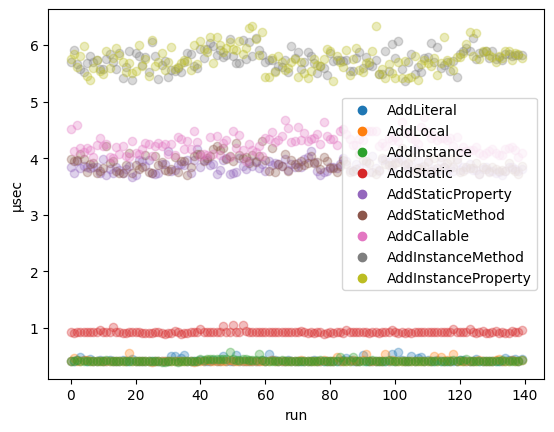

In [15]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "AddLocal", "AddInstance", "AddStatic", "AddStaticProperty", "AddStaticMethod", "AddCallable", "AddInstanceMethod", "AddInstanceProperty"
], alpha=0.3)


Vidíme, že přičítání literálu, lokální a instanční proměnné, jsou všechny zhruba stejně rychlé. Statická proměnná je několikrát pomalejší.   

Volání metody či property getteru je nepřekvapivě ještě o další řád pomalejší, avšak v tomto případě vítězí zhruba o polovinu statické metody nad instančními.

> Zběžným prokrokováním interpreteru v debuggeru (release build) vypozorujeme toto:
 - u instanční funkce logika opcodu `OPCODE_CALL` zavolá `Variant::callp(..)` (nevirtuální, poměrně krátká, přesto se neinlinovala) - ten sezdá, že v něm je uložena hodnota typu `Object` -> virtuálně zavolá `Object::callp()` - ten vezme instanci svého skriptu a na ní virtuálně zavolá `GDScriptInstance::callp(..)`, ta již v tabulce dohledá odpovídající funkci (popř. pokud nenalezne, prochází hierarchii děděných tříd) a virtuálním voláním `GDScriptFunction::call()` spustí její instanci interpreteru
 - u statické funkce logika opcodu `OPCODE_CALL` rovněž zavolá `Variant::callp(..)`, ten obdobně zavolá virtuální `Object::callp(..)` - avšak ta je rovnou overridována na `GDScript::callp()` - v ní již dohledáme v tabulce odpovídající funkci (rovněž příp. iteruje skrz hierarchii děděných tříd) a virtuálním voláním `GDScriptFunction::call()` spustí její instanci interpreteru. Zredukovali jsme tedy jedno virtuální volání.  
>_call stack pro statické volání_   
 ![VM Call stack for static call](./img/static_call-vm_call_stack.png)   
> _call stack pro instanční volání_   
 ![VM Call stack for instance call](./img/instance_call-vm_call_stack.png)   
> Poněkud těžké uvěřit, že jedno virtuální volání může nést takovou váhu v porovnání např. s lookupem funkce v hešmapě (dle stringu, ale se zaručeným agresivním internováním - tedy ekvivalentní s porovnáváním pointerů), avšak lepší vysvětlení mě zatím nenapadá. Pokud si v debuggeru rozkliknu hešmapu, ve které hledá `GDScript::callp()`, shledám, že v ní jsou uložené všechny - jak statické, tak lokální metody - tedy rozhodně nejde o důsledek toho, že by statická varianta prohledávala menší tabulku apod., i když nelze vyloučit že zrovna v mém případě např. vyšla nešikovná kolize hešů.

Volání statické metody skrze `Callable` je nepřekvapivě mírně pomalejší než její volání přímo, avšak rozdíl je menší, než by intuitivně bylo lze čekat.   
Podívejme se nyní ještě detailněji pouze na přístupy k proměnným:

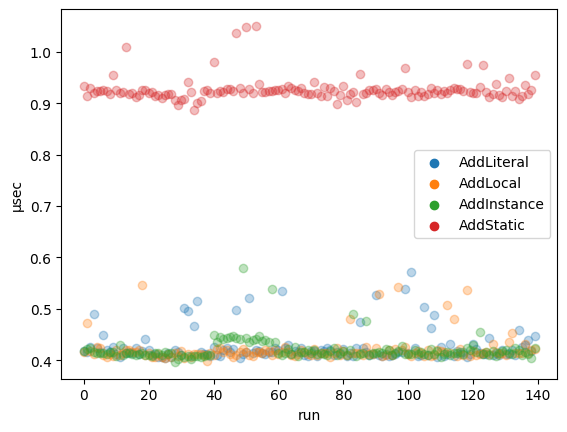

In [16]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "AddLocal", "AddInstance", "AddStatic"
], alpha=0.3)


Ano, statická proměnná se skutečně zdá být citelně pomalejší. Mějme na paměti, že měření v sobě také zahrnují overhead operace sčítání a uložení do lokální proměnné, statická proměnná je tedy oproti lokální/instanční o dost více než 2-krát pomalejší.     
K vysvětlení stačí nahlédnout na vygenerovaný bytekód...
> Uvažujme nejjednodušší příklad:
```py
var dummy : int = 478
func foo():
    var v :int
    v = dummy
```
Disassembler vypadá takto:
```asm
 0: _
 2: construct validated stack(3) = int()
 7: _
 9: assign stack(3) = member(dummy)
```
Přístup k `dummy` je součástí instrukce. Samotný handler `OPCODE_ASSIGN` si pouze ze stacku přečte dva pointery a zkopíruje hodnotu z jednoho do druhého. 
Změníme-li `dummy`, na statickou proměnnou, musíme ji přečíst explicitně skrze dodatečnou instrukci `OPCODE_GET_STATIC_VARIABLE`, jejíž handler navíc kdesi ve svých hlubinách vykonává relativně drahý `dynamic_cast`.
```asm
 0: _
 2: construct validated stack(3) = int()
 7: _
 9: get_static_variable stack(4) = script(tool_test.gd)["dummy"]
 13: assign stack(3) = stack(4)
```
Všeobecně, pro konstanty, lokální a instanční proměnné se zdá, že přístup k nim máme "zdarma" jako součást instrukce, což platí jak pro load, tak store.  

Nyní když víme, že lokální proměnná, literál a instanční proměnná, jsou nejrychlejší, zaměřme se nyní na porovnání rychlosti různých aritmetických operací.

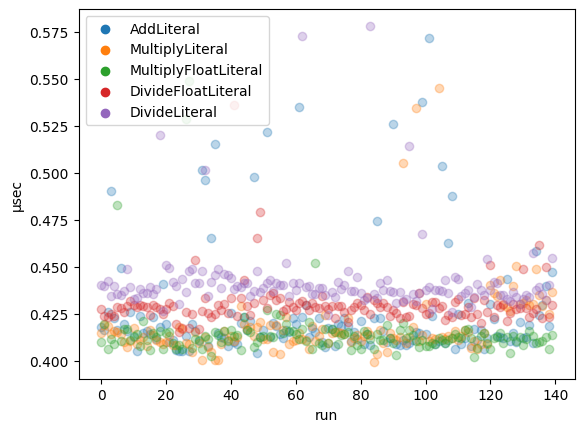

In [17]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "MultiplyLiteral", "MultiplyFloatLiteral",
	"DivideFloatLiteral", "DivideLiteral", 
	#"AddLocal_Vector2i", "AddLocal_Vector2f", "AddLocal_Vector3i", "AddLocal_Vector3f", "MultiplyLocal_Vector4f"
], alpha=0.3)


Mezi sčítáním a násobení intů i floatů je dostatečně malý rozdíl, aby se s přehledem schoval do overheadu interpreteru. Dělení je dostatečně drahá operace, aby již byla měřitelně (pořád v praxi zanedbatelně) pomalejší.    
Přibližme pouze na sčítání/násobení:   

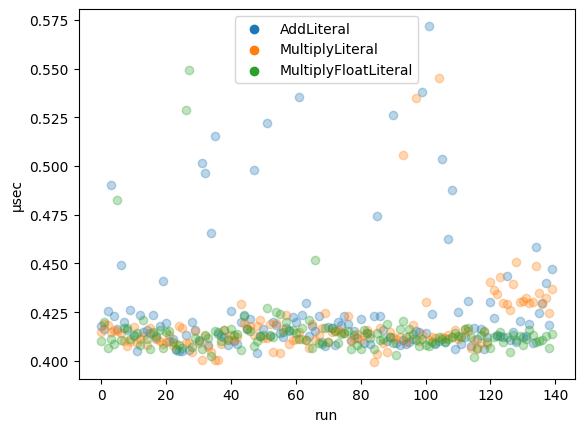

In [18]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "MultiplyLiteral", "MultiplyFloatLiteral",
], alpha=0.3)


V herní logice často pracujeme s 2 či 3-rozměrnými vektory. Jsou jejich operace natolik rychlé, aby dohromady s overheadem interpreteru byly srovnatelně rychlé jako skalární aritmetika?

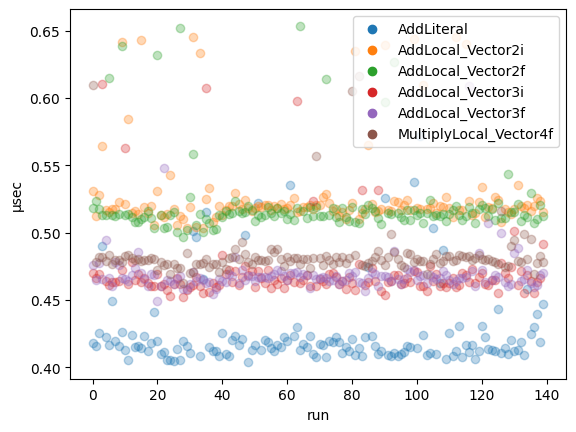

In [19]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral",
	"AddLocal_Vector2i", "AddLocal_Vector2f", "AddLocal_Vector3i", "AddLocal_Vector3f", "MultiplyLocal_Vector4f"
], alpha=0.3)


Vektorové operace jsou pomalejší než skalární jen velmi zanedbatelnou mírou. Je zajímavé, že 2D vektory jsou pomalejší než 3D/4D, možná se u větších vektorů používá SIMD instrukce zatímco 2D je ponechán s dvěmi skalárními (to by vysvětlilo téměř nulový rozdíl mezi 3D a 4D vektorem), v každém případě rozdíl není natolik značný, aby lákal k průzkumu.   
Je třeba nést na paměti, že vektory standardně nesou 32-bitové floaty (možné změnit flagem při kompilaci enginu), kdežto skalární float je vždy 64-bitový.    

Podívejme se nyní na složitější skalární funkce. 

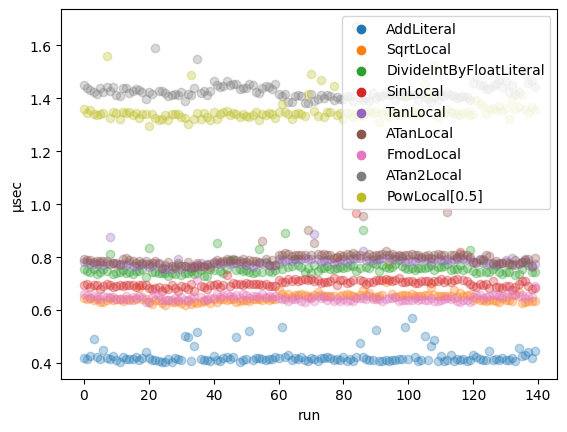

In [20]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "SqrtLocal", "DivideIntByFloatLiteral",
	"SinLocal", "TanLocal", "ATanLocal", "FmodLocal", "ATan2Local", ("PowLocal", "0.5")
], alpha=0.3)


Vidíme, že většina funkcí je nanejvýš dvakrát pomalejší než sčítání. Vydělení intu floatem a uložení do intu, je zhruba stejně pomalé jako spočítání atan z floatu a uložení do floatu.  
Sqrt je o tolik zanedbatelně pomalejší, že operace nad druhou mocninou délky místo reálné délky vektoru programátor v GDScriptu dělá spíše ze zvyku, než že by tím měl jakýkoliv reálný vliv na výkon. Pow a Atan2 jsou o trochu pomalejší, ale stále by z jejich použití programátor neměl mít výčitky.       
Samozřejmě tyto závěry, vyvozené z jednoho konkrétního stroje není záhodno brát příliš vážně. Jiná CPU mohou mít matematické instrukce o tolik pomalejší, že tu bude patrný značnější rozdíl.     

##### Constant folding

Nyní se zaměřme na optimalizace, které kompilátor nad kódem provádí - jmenovitě constant folding.   

První z benchmarků nese payload `ret += 42`, druhý `ret += 21 + 9 + 7 + 5 * 1` (kde `var ret: int = 1`)


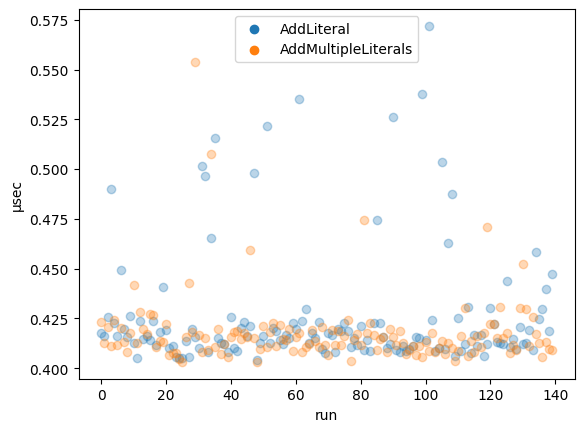

In [21]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"AddLiteral", "AddMultipleLiterals"
], alpha=0.3)

Zde máme payloady `ret *= 17.0` a `ret *= (1.0/0.0588)` (opět `var ret: float = 1.0`)

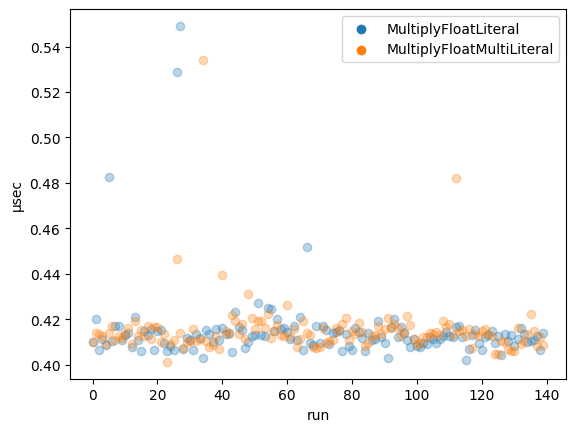

In [22]:
graph_usecs(all_measurements[ArithmeticBenchmarks], [
	"MultiplyFloatLiteral", "MultiplyFloatMultiLiteral"
], alpha=0.3)

Výsledky jsou pro obě varianty srovnatelné, ke constant foldingu tedy zajisté dochází, alespoň pro základní aritmetické operace.    

Postavme nyní proti sobě varianty, kde payload je pouze `pass` (prázdný příkaz), součet intových literálů, stringový literál a konkatenace více stringových literálů - ve všech případech dostaneme zhruba stejný čas běhu. Konstanty tedy s největší pravděpodobností byly zahozeny.   

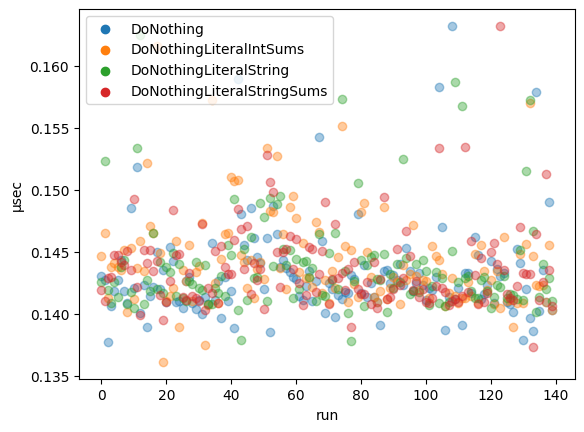

In [23]:
graph_usecs(all_measurements[ArithmeticBenchmarks], ["DoNothing", "DoNothingLiteralIntSums", "DoNothingLiteralString", "DoNothingLiteralStringSums"], alpha=0.4)

Domněnku můžeme potvrdit nahlédnutím do disassembleru, ten pro všechny funkce vypadá shodně:
```asm
 0: _
 2: call method-bind validated (return) stack(9) = const(object(Time)).get_ticks_usec()
 8: assign stack(5) = stack(9)
 11: _
 13: assign stack(8) = stack(3)
 16: for-init (typed INT) stack(6) in stack(8) counter stack(7) end 130
 21: jump 28
 23: for-loop (typed INT) stack(6) in stack(8) counter stack(7) end 130
 28: _
 30: _
 32: _
 34: _
 ...
 126: _
 128: jump 23
 130: _
 132: call method-bind validated (return) stack(10) = const(object(Time)).get_ticks_usec()
 138: validated operator stack(9) = stack(10) - stack(5)
 143: return stack(9)
 145: == END ==

```

Povšimněme si mnoha řádek, na kterých se opakuje `_`. To je `OPCODE_LINE`, který GDScript emituje pro každou řádku kódu - nic nedělá, pouze zabírá 4B místa a slouží k orientaci při debugování. Pokud počet příkazů `pass` zdvojnásobíme (v tomto případě 50->100), zhruba se zdvojnásobí i doba vykonávání tohoto prázdného benchmarku. Nahlédneme-li do zdrojového kódu, zjistíme že emitování `OPCODE_LINE` je naštěstí schované za ifdefem, který je aktivní pouze při buildování editoru. Finální export spustitelné hry tedy tento drobný overhead nemusí platit a i proto poběží mírně rychleji.  

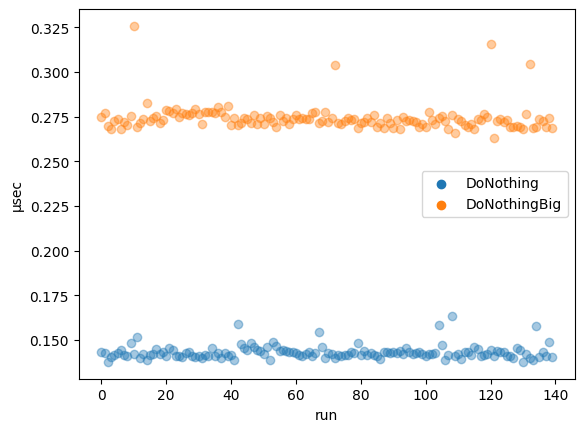

In [24]:
graph_usecs(all_measurements[ArithmeticBenchmarks], ["DoNothing", "DoNothingBig"], alpha=0.4)

Ještě jsme vyzkoušeli "prázdné" příkazy, kde opakovaně čteme stejnou hodnotu z pole, hešmapy nebo property abychom ji následně zahodili, popř. kde zapisujeme stále stejnou hodnotu do lokální proměnné.    
Jak vidíme, žádná z těchto operací nebyla odoptimalizována pryč, kompilátor je vždy tupě vygeneruje. (Příp. lze potvrdit nahlédnutím na bytekód)  
> Asi to tak dává smysl, protože z určitého pohledu indexování vlastně je operací, která může mít sideefekt (chybovou hlášku když jsme out-of-bounds). Podobně property getter může technicky obsahovat arbitrární logiku se sideefekty.  

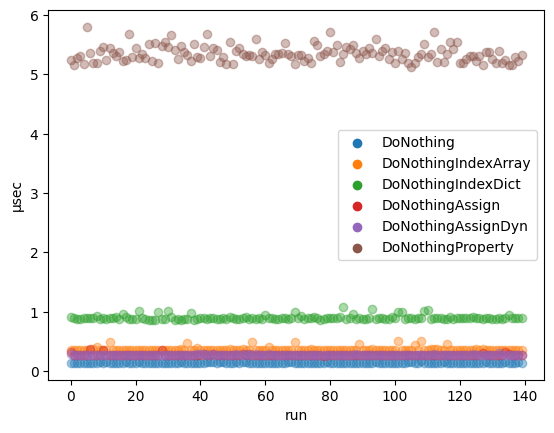

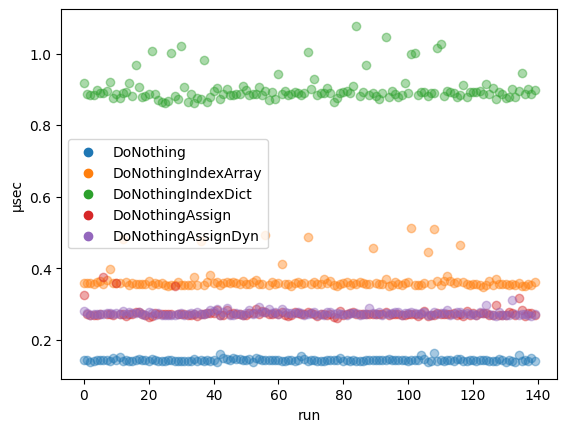

In [25]:
graph_usecs(all_measurements[ArithmeticBenchmarks], ["DoNothing", "DoNothingIndexArray", "DoNothingIndexDict", "DoNothingAssign", "DoNothingAssignDyn", "DoNothingProperty"], alpha=0.4)
graph_usecs(all_measurements[ArithmeticBenchmarks], ["DoNothing", "DoNothingIndexArray", "DoNothingIndexDict", "DoNothingAssign", "DoNothingAssignDyn"], alpha=0.4)


------------------------------------
#### Iterace

Zde porovnáme různé metody, jak iterovat přes sekvence hodnot. Primárně se zaměříme na číselné posloupnosti, protože pro ty nám jazyk nabízí hned několik vestavěných možností.   
Všechny použité benchmarky iterují přes interval `<0;200)` a minimální smyslplnou činností, kterou při iteraci vykonávají (aby byla rychlost iterace zasazena trochu do kontextu) je přičítání aktuálního indexu k lokální akumulátor-proměnné.  
V této sekci již příležitostně budeme narážet na dynamickou alokaci paměťi.   

První metodou, o které se typický začátečník dočte v tutoriálu, je iterovat `for i in range(0, 200)`. Porovnejme ji s manuálním iterováním skrze `while` cyklus a lokální proměnnou, již explicitně inkrementujeme. Dle dokumentace by `range(begin, end, step=1)` měl vytvořit **pole** prvků `begin..end`.

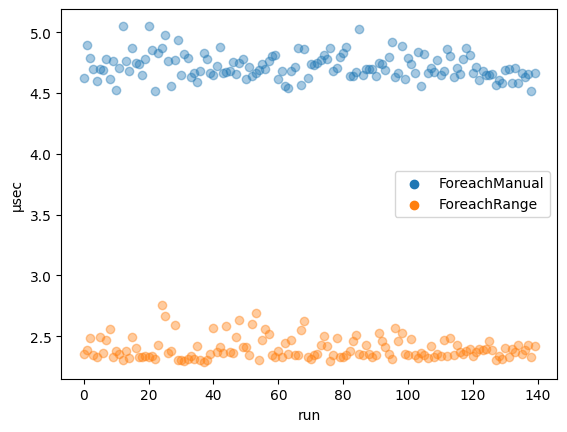

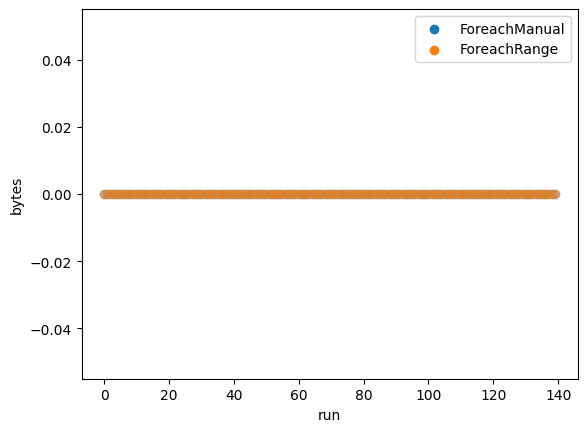

In [26]:
multigraph([all_usecs, all_alloc_bytes], all_measurements[IterationBenchmarks], ["ForeachManual", "ForeachRange"], alpha=0.4)

Jak vidíme, `for i in range` je o poznání rychlejší. Navzdory tomu, co je psáno v dokumentaci, rovněž nealokuje žádné pole na haldě. Je chvályhodné, že dokumentací propagovaná cesta je zároveň ta rychlá. Pokračujme nyní dále a dojdeme vysvětlení.   

Godot dále nabízí špatně dokumentovanou, leč intuitivní, možnost iterovat přímo `for i in 200`. Nahlédnutím na seznam opcodů jsme dále objevili, že existují dedikované instrukce pro iteraci přes 2D a 3D vektory - zběžným otestováním zjistíme, že chování `for i in Vector2i(0, 200)` je obdobné jako `for i in range(0, 200)`, co však výkon?    

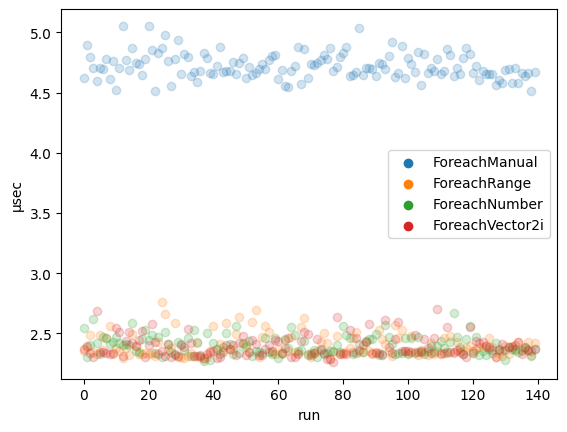

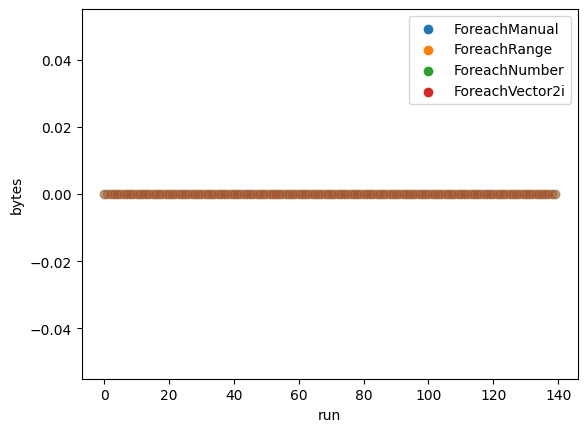

In [27]:
multigraph([all_usecs, all_alloc_bytes], all_measurements[IterationBenchmarks], [ "ForeachManual", "ForeachRange", "ForeachNumber", "ForeachVector2i"], alpha=0.2)

Výkon je identický. Vysvětlení je na snadě - nahlédneme-li do disassembleru, zjistíme, že překladač použití `range(..)` přepíše právě na iteraci přes skalár/2D/3D vektor (dle toho, zda vidí volání range s 1/2/3 argumenty). Disassembler benchmarku `ForeachRange` a `ForeachVector2i` je identický.   

Prozkoumejme nyní blíže, kdy k optimalizaci dochází. Napsali jsme několik variant s drobnými odlišnostmi - kdy např. argument `range()` je proměnná, podmíněný výraz apod.; kdy výsledek `range()` nejprve uložíme do proměnné a teprve potom přes něj iterujeme, atd. .


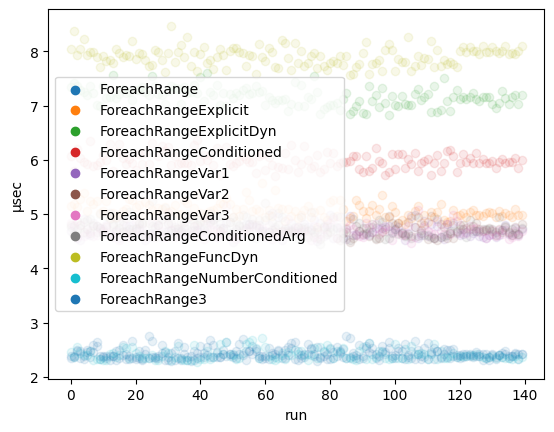

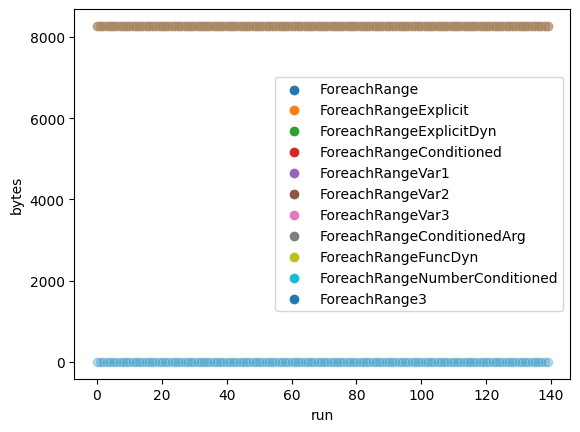

Variants that allocate: ['ForeachRangeExplicit', 'ForeachRangeExplicitDyn', 'ForeachRangeConditioned', 'ForeachRangeVar1', 'ForeachRangeVar2', 'ForeachRangeVar3', 'ForeachRangeConditionedArg', 'ForeachRangeFuncDyn']
Variants that don't allocate: ['ForeachRange', 'ForeachRangeNumberConditioned', 'ForeachRange3']


In [28]:
temp = [
    "ForeachRange",  "ForeachRangeExplicit", "ForeachRangeExplicitDyn", "ForeachRangeConditioned",
    "ForeachRangeVar1", "ForeachRangeVar2", "ForeachRangeVar3", "ForeachRangeConditionedArg", "ForeachRangeFuncDyn", "ForeachRangeNumberConditioned",
    "ForeachRange3"
]

multigraph([all_usecs, all_alloc_bytes], all_measurements[IterationBenchmarks], temp, alpha=0.1)

print("Variants that allocate: %s"%(get_with_condition(all_measurements[IterationBenchmarks], temp, lambda m: any(all_allocs(m))    )))
print("Variants that don't allocate: %s"%(get_with_condition(all_measurements[IterationBenchmarks], temp, lambda m: all([1 if a == 0 else 0 for a in all_allocs(m)])    )))

Měření srovnáváme tolik najednou, že graf přestává být přehledný. K orientaci nám zde však stačí výčet, které benchmarky alokovaly, a které nealokovaly.   
Vidíme, že k optimalizaci dochází prakticky jen v nejzákladnějším případě, kdy všechny argumenty `range()` jsou konstantní výrazy. 
`ForeachRangeNumberConditioned` volá `range(0, (200 if true else 200))`, což se zřejmě zconstant-folduje.    
 - Stačí však `true` ve výrazu vyměnit za proměnnou, a optimalizace je ztracena (viz `ForeachRangeConditionedArg`). 
- Pokud samotné volání `range()` vykonáváme uvnitř podmíněného výrazu (viz `ForeachRangeConditioned`), je optimalizace ztracena i pokud podmiňujeme konstantou (`range(..) if true else range(..)`).  
- Pokud kterýkoliv z argumentů změníme z konstanty na proměnnou, byť typovanou jako `int`, optimalizace se vytrácí (viz `ForeachRangeVar1/2/3`). 
- Stejně tak pokud výsledek volání `range()` uložíme do proměnné (ať už dynamické či typované jako `Array`), či pokud ho navracíme z pomocné funkce.

**Rozšířit rozsah optimalizace přinejmenším na běžný případ, kdy argumenty jsou lokální proměnné typu int, by mohlo mít nezanedbatelný přínos pro výkon mnoha v Godotu napsaných her.**

Nyní se zaměřme na iterace přes datové struktury.  
Struktury jsme si vytvořili předem a inicializovali je, aby na indexech 0..200 obsahovaly čísla odpovídající indexu.   
Výsledky jsou víceméně jaké bychom předpokládali - iterace přes zoptimalizovaný `range()` je nejrychlejší, varianty `PackedArray` jsou hned další, standardní `Array` je pomalejší, protože každá položka je v něm uložena jako 24-bytový `Variant` - avšak čím silněji typovaný, tím je rychlejší:   
   - `ForeachArrayPacked32/64` deklaruje své pole jako `var arr: PackedInt32/64Array = []`   
   - `ForeachArrayTyped` deklaruje své pole jako `var arr: Array[int] = []`   
   - `ForeachArray` deklaruje své pole jako `var arr: Array = []`   
   - `ForeachArrayDyn` deklaruje své pole jako `var arr: Variant = []`   
Obdobně platí pro `Dictionary` (který přirozeně neručí za iterační pořadí). Plně dynamické pole je pomalejší než manuální iterace a v našem specifickém případě velmi podobně rychlé jako plně typované `Dictionary[int, int]`.   
Žádná z datových struktur při iteraci neměla potřebu interně alokovat paměť, což je příčetné.       


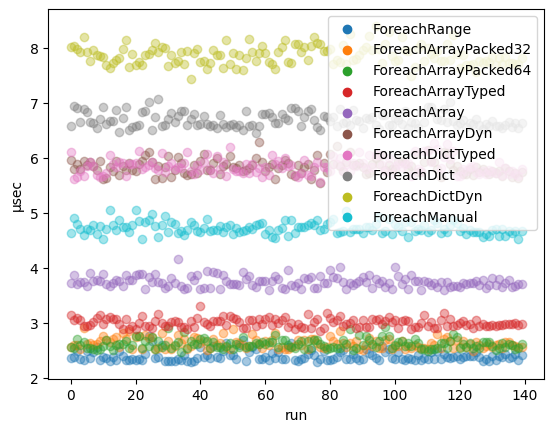

Variants that allocate: []


In [29]:
temp = [
    "ForeachRange", "ForeachArrayPacked32", "ForeachArrayPacked64", "ForeachArrayTyped", "ForeachArray", "ForeachArrayDyn",
    "ForeachDictTyped", "ForeachDict", "ForeachDictDyn", "ForeachManual"
]
multigraph([all_usecs], all_measurements[IterationBenchmarks], temp, alpha=0.4)
print("Variants that allocate: %s"%(get_with_condition(all_measurements[IterationBenchmarks], temp, lambda m: any(all_allocs(m))    )))



Obdobně jako přes 2D/3D vektor `int`ů, existuje nedokumentovaná podpora i pro iteraci přes vektor `float`ů. Výsledek má stejné chování, akorát iterační proměnná bude typovaná jako `float`:

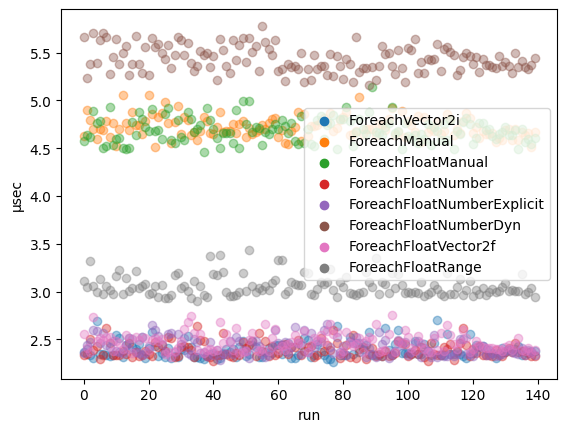

Variants that allocate: []


In [30]:
temp = [
    "ForeachVector2i", "ForeachManual", "ForeachFloatManual",
    "ForeachFloatNumber", "ForeachFloatNumberExplicit", "ForeachFloatNumberDyn", "ForeachFloatVector2f", "ForeachFloatRange",
]
multigraph([all_usecs], all_measurements[IterationBenchmarks], temp, alpha=0.4)
print("Variants that allocate: %s"%(get_with_condition(all_measurements[IterationBenchmarks], temp, lambda m: any(all_allocs(m))    )))

Pokud uživatel z jakéhokoliv důvodu potřebuje `float`ovou řidící proměnnou, iterace přímo přes `Vector2` je o trochu rychlejší než iterace přes `int` a následná konverze na float (viz `ForeachFloatRange`).   
Manuální iterace přes floaty je stejně pomalá jako manuální iterace přes inty.  
Iterace přes proměnnou nesoucí `float`, ale deklarovanou jako dynamická (viz `ForeachFloatNumberDyn`), je citelně pomalejší než při silném typování.    

----------------------------------
#### Konverze
V následující sekci se zaměříme na rozličné konverze.    
Následující mikrobenchmarky opět budou používat formát, kdy v jedné iteraci je payload copypastovaný 50-krát za sebou.  

Nejprve konverze mezi skalárními typy.   
V následujících benchmarcích výsledek konverze přičítáme k lokálnímu akumulátoru, deklarovanému s cílovým typem na který konvertujeme.    

Vidíme, že vykonat konverzi `int`->`float` tak, že proměnnou vynásobíme `*1.0` je nepatrně rychlejší než volat vestavěný konstruktor `float(i)`.   
Konverze `float`->`int` pomocí vestavěného konstruktoru `int(f)` je stejně rychlá, avšak chová se mírně netradičně - místo aby brala spodní celou část, jak je zvykem v jazyce C a jeho příbuzných, osekává číslice za desetinnou čárkou. Pokud chceme spodní celou část, typovanou jako `int`, musíme volat funkci `floori(i)`, která, jak vidíme, je cca o 25% pomalejší.

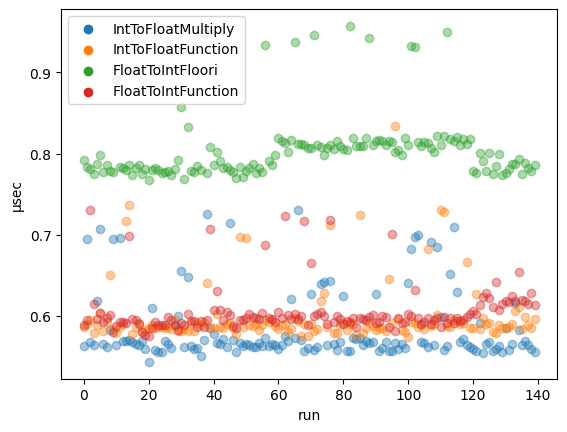

In [31]:
multigraph([all_usecs], all_measurements[ConversionBenchmarks], [
    "IntToFloatMultiply", "IntToFloatFunction", "FloatToIntFloori", "FloatToIntFunction"
], alpha=0.4)

Jak co nejrychleji vykonávat konverze mezi jednotkami - zde např. z radianů na stupně?   
Můžeme buď použít vestavěnou metodu `rad_to_deg()`, nebo násobit konverzní konstantou.    
Vidíme, že násobení konverzní konstantou je o trochu rychlejší, pokud je konstanta lokální proměnná. V těsné smyčce by toto mohla být validní mikrooptimalizace.   
Pokud bychom tento přístup měli aplikovat globálně systematicky, chtěli bychom pravděpodobně deklarovat konverzní konstantu jako globálně viditelnou statickou proměnnou. Jak již víme, statické proměnné jsou pomalé - v tomto případě dodatečný overhead převáží, a vestavěná konverzní funkce je rázem ta citelně rychlejší.    

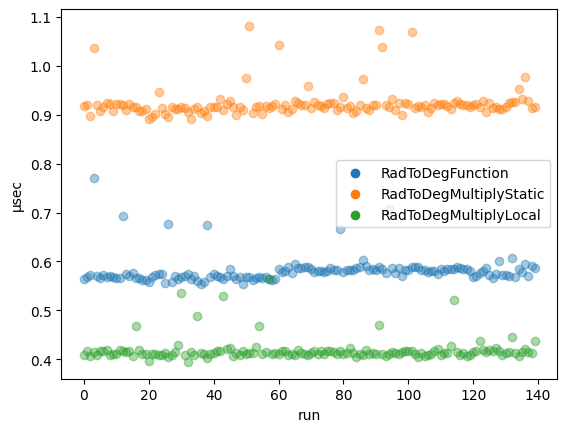

In [32]:
multigraph([all_usecs], all_measurements[ConversionBenchmarks], [
   "RadToDegFunction", "RadToDegMultiplyStatic", "RadToDegMultiplyLocal",
], alpha=0.4)

Co konverze čísla na text?
Můžeme použít vestavěný konstruktor `str(i)`, nebo použít jednu ze dvou obecnějších metod pro textové formátování:
 - `String::operator %` používá formátovací řetězec ala `printf`, pravým argumentem může být buď pole, nebo přímo hodnota
 - `String::format()` používá formátovací řetězec se složenými závorkami ala .NET. Argument musí být vždy pole nebo tabulka.

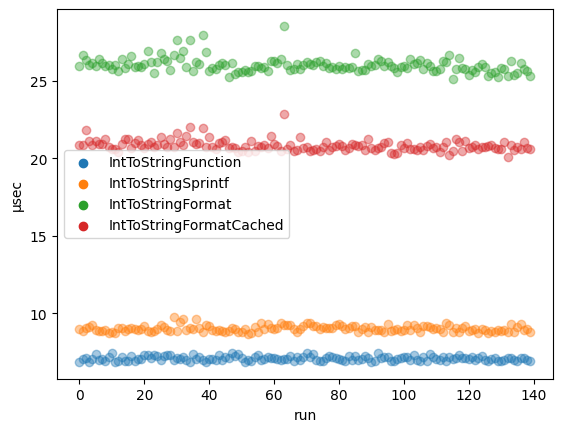

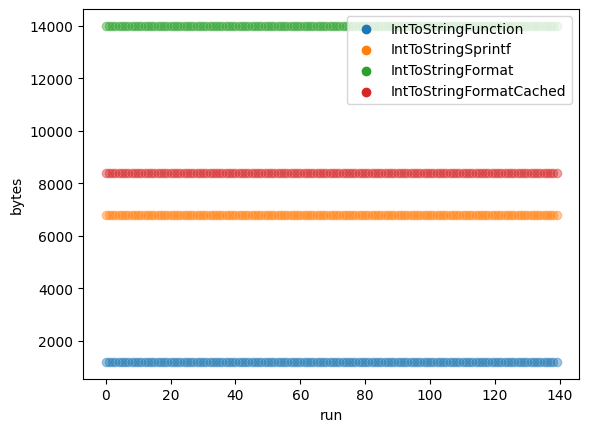

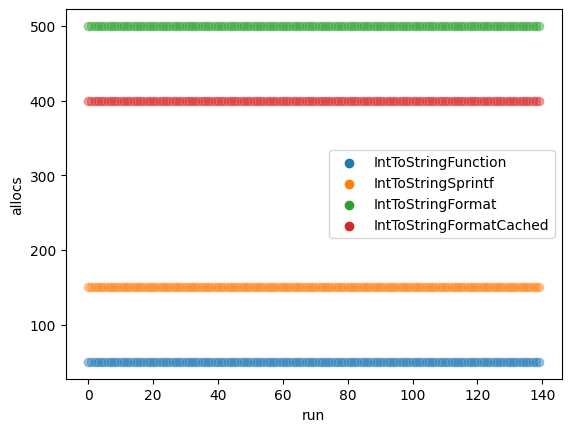

{'allocated_bytes': {'IntToStringFunction': 24,
  'IntToStringSprintf': 136,
  'IntToStringFormat': 280,
  'IntToStringFormatCached': 168},
 'alloc_calls': {'IntToStringFunction': 1,
  'IntToStringSprintf': 3,
  'IntToStringFormat': 10,
  'IntToStringFormatCached': 8},
 'realloc_calls': {'IntToStringFunction': 1,
  'IntToStringSprintf': 3,
  'IntToStringFormat': 10,
  'IntToStringFormatCached': 8}}

In [70]:
temp = [
    "IntToStringFunction", "IntToStringSprintf", "IntToStringFormat", "IntToStringFormatCached",
]
multigraph([all_usecs, all_alloc_bytes, all_allocs], all_measurements[ConversionBenchmarks], temp, alpha=0.4)

allocations_preview(all_measurements[ConversionBenchmarks], temp, 50)


> Přibližme na konverzní funkci a `operator %`:

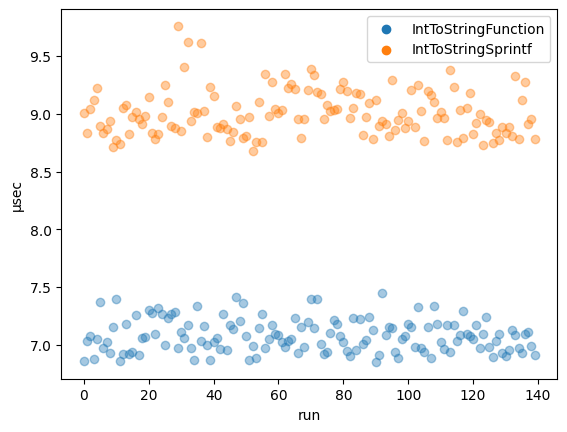

In [34]:
multigraph([all_usecs], all_measurements[ConversionBenchmarks], ["IntToStringFunction", "IntToStringSprintf"], alpha=0.4)

Překvapivě rozdíl mezi konstruktorem a operátorem `%` není tak značný, jak by napovídala intuice.   
Oproti tomu `String.format` se zdá být násobně pomalejší. Část overheadu spočívá v konstrukci pole, ve kterém musí být předán číselný argument, naměřili jsme tedy i variantu, kde pole alokujeme předem a v payloadu do něj pouze argument zapíšeme (`IntToStringFormatCached`) - tím jsme citelnou část overheadu zredukovali, avšak v rychlosti i ve spotřebě paměti operátor `%` stále výrazně vítězí.   

Zběžně jsme otestovali jak operátor `%` škáluje, pokud máme na formát tisknutého čísla specifické požadavky.    
Vidíme, že pro složitější formátovací řetězec může doba běhu a množství alokací vzrůst i několikanásobně. Složitější formátovací řetězce, které tisknou několik hodnot, jsme ani neuvažovali.   
Aplikace, která by z jakéhokoliv důvodu používala řetězcové formátování ve výkonově-kritickém kontextu, zcela jistě bude muset vykonat svá vlastní podrobnější měření, nebudeme tedy zabředávat hlouběji.           

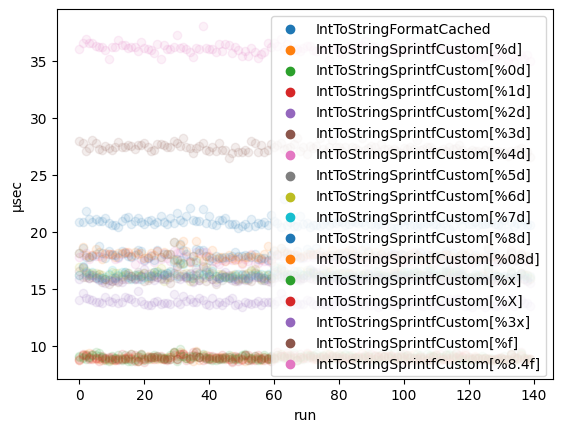

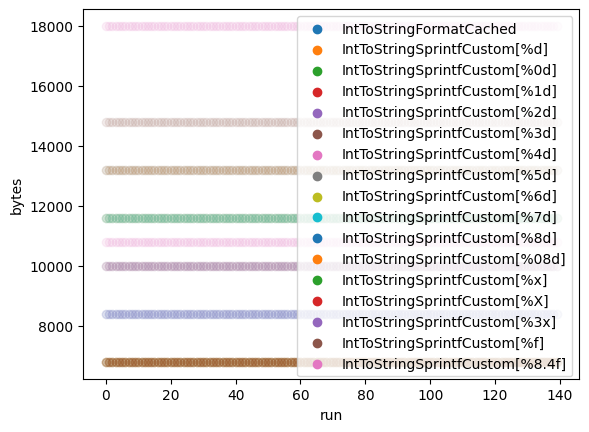

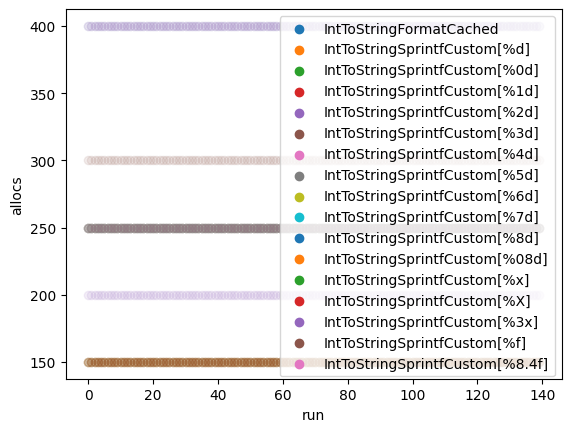

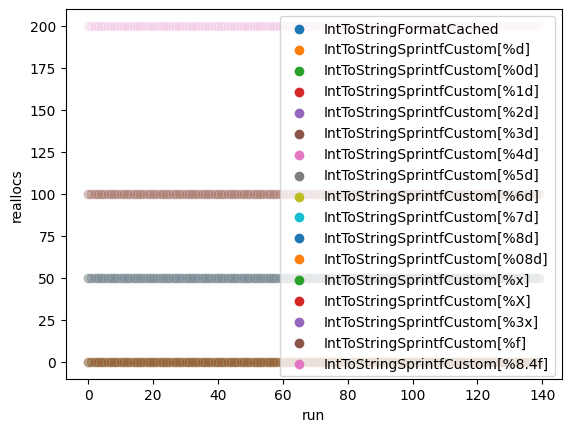

In [35]:

multigraph([all_usecs, all_alloc_bytes, all_allocs, all_reallocs], all_measurements[ConversionBenchmarks], ["IntToStringFormatCached", "IntToStringSprintfCustom"], alpha=0.1)


---------------------------------
#### Volání funkcí

V této sekci se hlouběji zaměříme na overhead spojený s voláním funkcí.   
Zdejší benchmarky opět mají formát, kde je payload 50-krát copypastovaný. Payloadem je typicky volání funkce, která okamžitě navrátí konstantu `42`.   
U žádného z benchmarků jsme nedetekovali alokace paměti.   



Pro volání metod máme v Godotu tři základní možnosti s různou mírou nepřímosti:
 - přímé volání (`instance.foo(arg)`) (pro něj měříme dvě varianty - v jedné je `instance` typovaná, ve druhé dynamická)
 - callback předaný jako objeckt typu `Callable` (`var callback : Callable = instance.foo ; callback.call(arg)`)
 - nepřímé volání přes metodu `call()` (`instance.call('foo', arg)`)

Pro instanční metody vidíme, že výkon přímého volání je stejný nezávisle na tom, zda známe typ objektu, a nepřímé volání přes `Callable` se zdá být možná i nepatrně rychlejší.   
**Je zřejmé, že GDScript zde nevyužívá znalost typu k žádným optimalizacím** - náprava tohoto stavu by pravděpodobně žádala větší systematické změny v interpreteru a míra potenciálního zrychlení je neznámá, avšak pravděpodobně nezanedbatelná a měla by vliv na téměř veškerý produkční kód v GDScriptu napsaný.    

Plně nepřímé volání skrze metodu `call` je cca o 30% dražší, což není vysoká daň za vrcholnou flexibilitu.   
Pokud se chceme nejprve dotázat zda metoda existuje a zavolat ji podmíněně (`if instance.has_method('foo'): instance.call('foo')`), vzroste nám čas volání na zhruba dvojnásobek.   

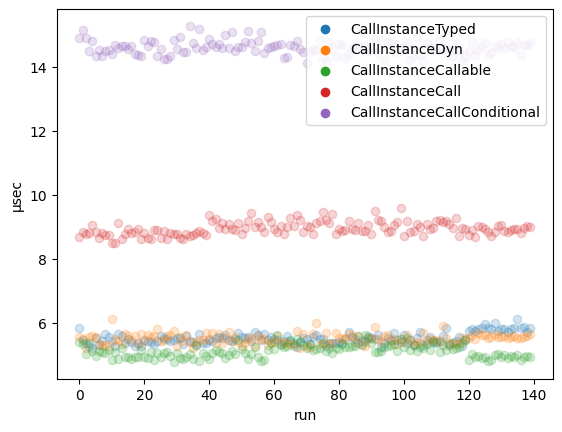

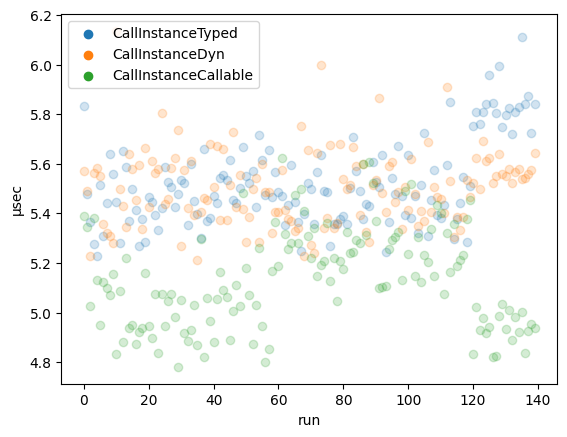

In [36]:

graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallInstanceTyped", "CallInstanceDyn", "CallInstanceCallable", "CallInstanceCall", "CallInstanceCallConditional",
], alpha=0.2)

graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallInstanceTyped", "CallInstanceDyn", "CallInstanceCallable"
], alpha=0.2)

Statická volání jsou všeobecně mírně rychlejší než instanční (již jsme vysvětlovali v sekci o aritmetice).  
Mezi oběmi variantami přímého volání a `Callable` zde vidíme nulový rozdíl. Překvapivě, pro volání přes `call()` nevidíme žádný výkonový propad, naopak je dokonce nepatrně rychlejší.   
Toto je velmi podivné - pokud to platí konzistentně, znamená to, že můžeme interpreter zrychlit, když zahodíme současnou separátní logiku, jež emituje kód pro volání statické funkce, a nahradíme ji emitováním volání `call` všude :D. Hlubší prozkoumání ponecháme pro případný navazující výzkum.      

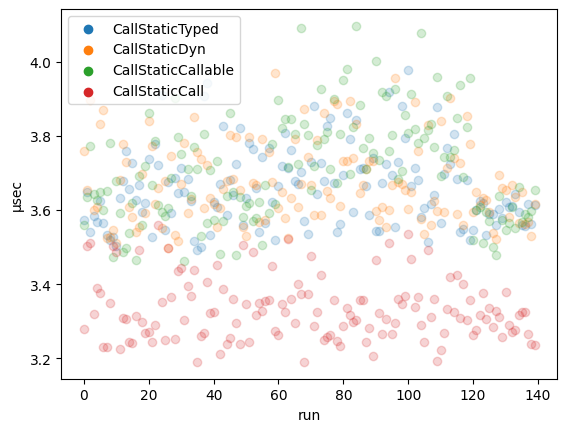

In [37]:

graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallStaticTyped", "CallStaticDyn", "CallStaticCallable", "CallStaticCall", 
], alpha=0.2)

Pro volání nativních C++ funkcí je výsledek takový, jaký bychom očekávali.    
Přímé volání je extrémně rychlé, téměř na úrovni čtení z GDScriptí proměnné - zde pravděpodobně není moc, co by se dalo více zoptimalizovat. Mezi funkcí nabindovanou jako statická, a jako instanční vidíme drobný rozdíl, stejně jako mají GDScriptí funkce.   

Volání přes `call` či `Callable` je o řád pomalejší a rozdíly mezi statickou a instanční funkcí se nám smívají. Rychlost volání roste cca očekávaným způsobem přímo úměrně s mírou dynamičnosti.  

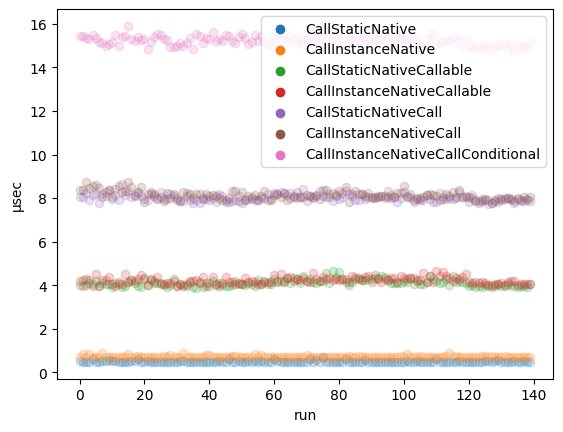

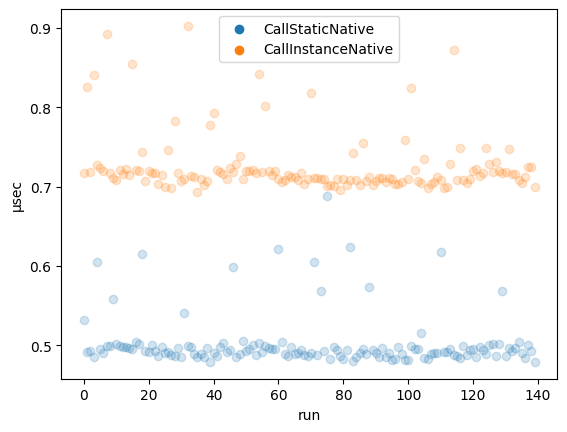

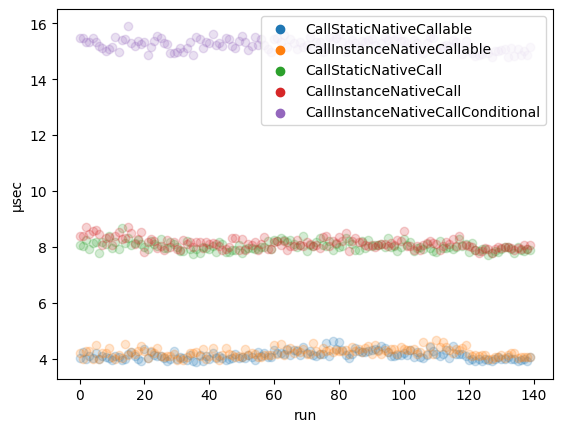

In [38]:

graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallStaticNative", "CallInstanceNative", "CallStaticNativeCallable", "CallInstanceNativeCallable", "CallStaticNativeCall", "CallInstanceNativeCall", "CallInstanceNativeCallConditional", 
], alpha=0.2)

graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallStaticNative", "CallInstanceNative"
], alpha=0.2)

graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallStaticNativeCallable", "CallInstanceNativeCallable", "CallStaticNativeCall", "CallInstanceNativeCall", "CallInstanceNativeCallConditional", 
], alpha=0.2)

Volání přes `Callable` má takový overhead, že se nám zhruba smívají rozdíly mezi nativní a managed funkcí.   
Podobně platí i pro `call()`.   
Upřímně je těžké si představit situaci, kdy by kdokoliv měl dobrý důvod volat nějakou nativní funkci skrze indirekci, vzhledem k tomu lze míru optimalizace považovat za překvapivě dobrou.    

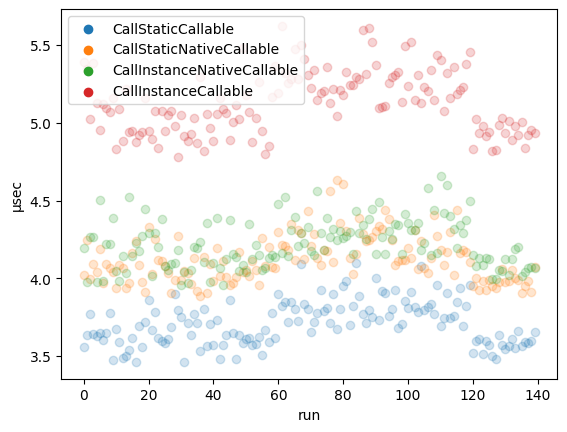

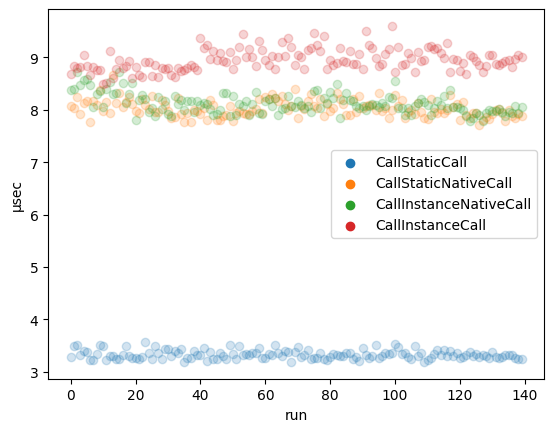

In [39]:
graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallStaticCallable", "CallStaticNativeCallable", "CallInstanceNativeCallable",  "CallInstanceCallable"
], alpha=0.2)

graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallStaticCall", "CallStaticNativeCall", "CallInstanceNativeCall",  "CallInstanceCall"
], alpha=0.2)

Jaký overhead má předávání funkčních argumentů?   
V této sekci jsme porovnávali funkce, kterým jsme předávali 12 argumentů typu `bool`.   
Měřili jsme tyto 4 varianty:
 - funkce deklaruje všechny argumenty jako `bool` (varianta `-Typed`)
 - funkce deklaruje všechny argumenty jako `Variant` (varianta `-Dyn`)
 - argumenty deklarované `bool`, voláme jako `Callable.call(true, true, true, ...)` 
 - argumenty deklarované `bool`, voláme jako `Callable.callv(args_array)` (pole argumentů připravené předem) 

Vidíme, že silně typovaná varianta je o trochu pomalejší než dynamická. Pravděpodobně GDScript ztrácí čas na začátku funkce procházením všech argumentů a assertováním, že skutečně jsou typu `bool` (jak jsme si již ukázali, interpreter nevykonává žádné optimalizace pro ne-dynamická volání, takže asi nemůže předpokládat, že toto již bylo vyřešeno na straně volajícího).   
Volání přes `Callable` a `CallableV` jsou překvapivě nepatrně rychlejší než přímé volání.

Tato pozorování platí naprosto identicky pro statická i instanční volání. Overhead předávání argumentů se zdá smýt veškeré rozdíly, které jsme mezi statickým a instančním voláním dříve zaznamenali.   

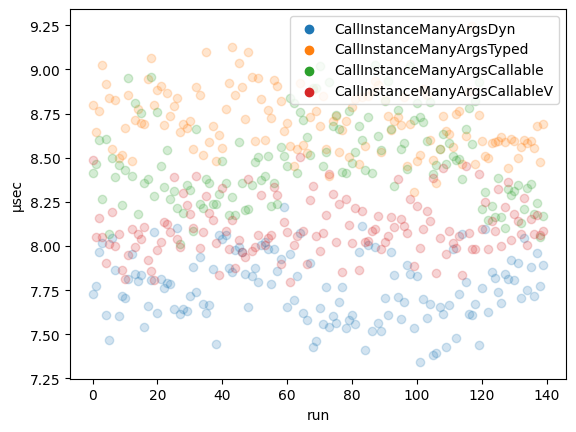

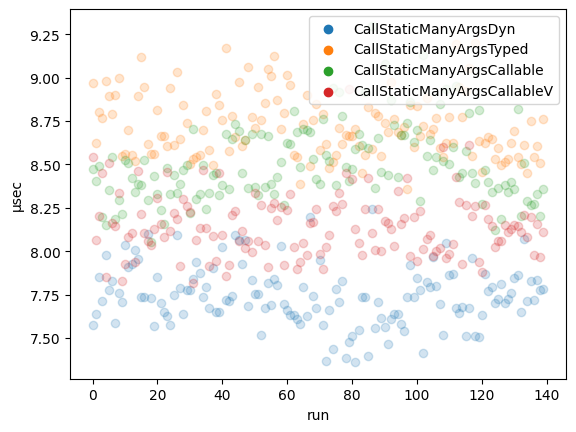

In [40]:
graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallInstanceManyArgsDyn", "CallInstanceManyArgsTyped", "CallInstanceManyArgsCallable", "CallInstanceManyArgsCallableV", 
], alpha=0.2)
graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallStaticManyArgsDyn", "CallStaticManyArgsTyped", "CallStaticManyArgsCallable", "CallStaticManyArgsCallableV", 
], alpha=0.2)

U nativních funkcí se situace obrací, plus rozdíly jsou o poznání výraznější.   
Argumenty typované `bool` jsou násobně rychlejší než obecný `Variant` - natolik rychlé, že se vrací patrný rozdíl mezi statickou a instanční funkcí.

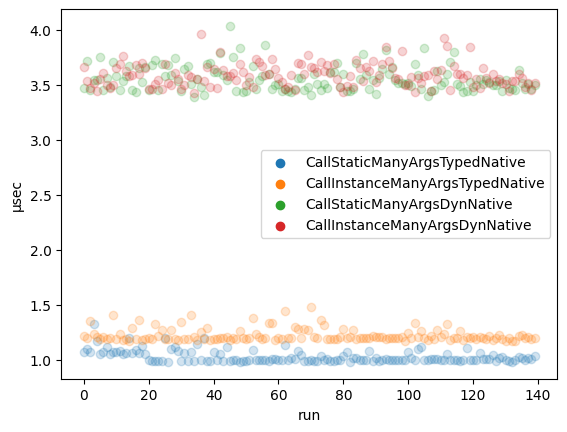

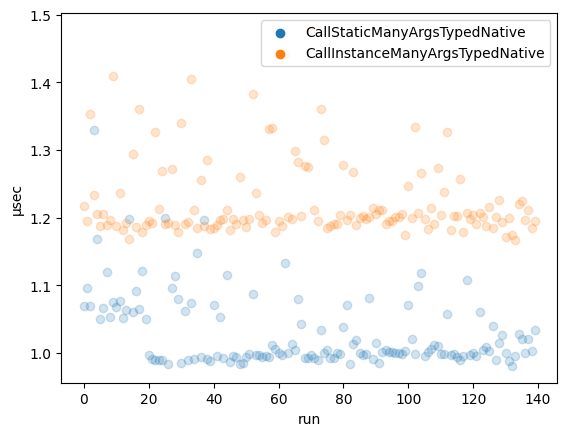

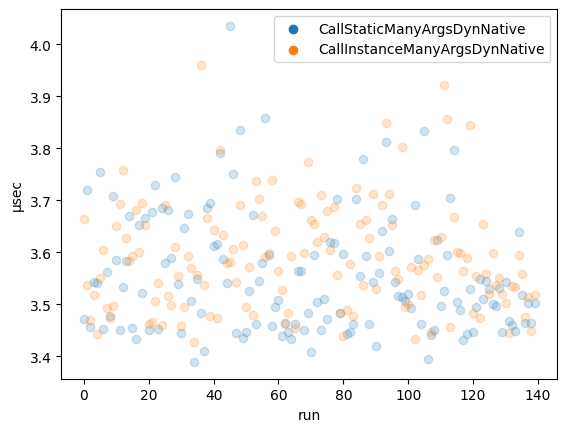

In [41]:
graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallStaticManyArgsTypedNative", "CallInstanceManyArgsTypedNative", "CallStaticManyArgsDynNative", "CallInstanceManyArgsDynNative", 
], alpha=0.2)
graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallStaticManyArgsTypedNative", "CallInstanceManyArgsTypedNative",
], alpha=0.2)
graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallStaticManyArgsDynNative", "CallInstanceManyArgsDynNative", 
], alpha=0.2)

Tipované argumenty jsou natolik rychlé, že oproti funkci bez argumentů se čas volání ani ne zdvojnásobí. 

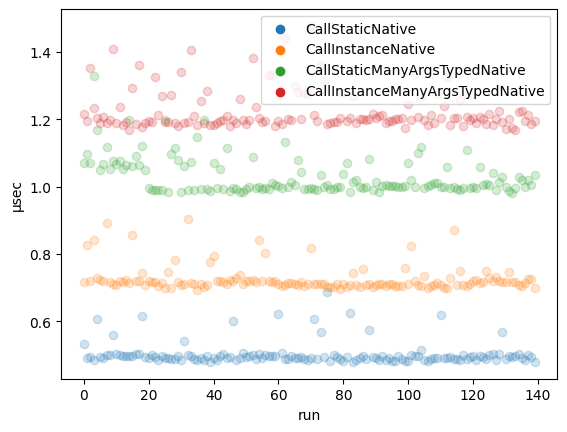

In [42]:

graph_usecs(all_measurements[FunctioncallBenchmarks], [
	"CallStaticNative", "CallInstanceNative", "CallStaticManyArgsTypedNative", "CallInstanceManyArgsTypedNative", 
], alpha=0.2)

Nyní ještě zběžně nahlédněme, jak roste čas volání v závislosti na počtu argumentů.  
V tomto parametrizovaném mikrobenchmarku jsme volali lambda-funkce se vzrůstajícím počtem argumentů skrze `Callable.callv()` (pole argumentů bylo předpřipravené).  
Ať už funkce přijímala tipované, nebo dynamické argumenty, růst času byl poměrově zhruba stejný, přibližně lineární.    

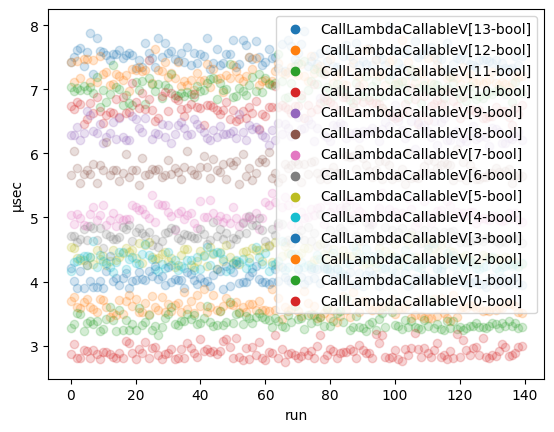

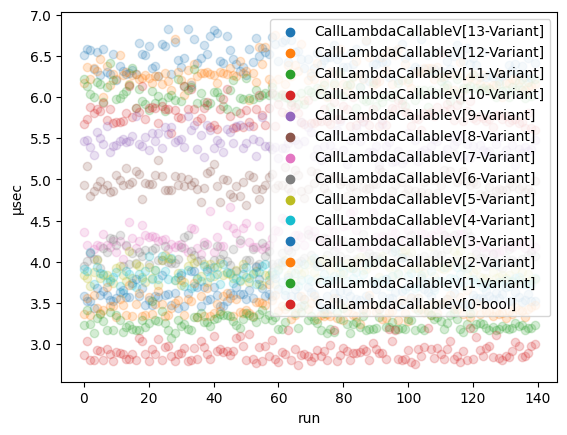

In [43]:

graph_usecs(all_measurements[FunctioncallBenchmarks], [("CallLambdaCallableV", "%d-bool"%(x,)) for x in range(13, 0, -1)] + [("CallLambdaCallableV", "0-bool")], alpha=0.2)
graph_usecs(all_measurements[FunctioncallBenchmarks], [("CallLambdaCallableV", "%d-Variant"%(x,)) for x in range(13, 0, -1)]+ [("CallLambdaCallableV", "0-bool")], alpha=0.2)

--------------------------------------
#### Datové struktury

Zaměřme se nyní na vestavěné datové struktury - nafukovací pole (`Array`) a hešmapu (`Dictionary`).   

Standardní `Array` může volitelně být anotovaný typovým argumentem, na který omezujeme prvky v něm uložené (např. `Array[int]`). Dle dokumentace, tento parametr může brát v úvahu kompilátor pro typovou inferenci, také např. při načítání do pole se na jeho základě mohou vykonávat dodatečné runtimové checky. Základní implementace je však stejná - bez ohledu na typ se vždy každá položka skladuje jako 24-bytový variant. Proto pro často používané primitivní typy existují specializované typy `Packed[SomePrimitiveType]Array`, které ukládají položky kompaktně (jako daň za to však nejsou s `Array` typově kompatibilní).   

`Dictionary` rovněž umožňuje typové parametry, ty se chovají obdobně jako u `Array`. Packed varianta zde neexistuje.    

> Názvosloví:
>    - pouze `Array`, `Dictionary` ve jménu mikrobenchmarku znamená, že datová struktura je typovaná `Array`/`Dictionary` bez typového parametru    
>    - `Array/DictionaryTyped` znamená plně otypovanou strukturu (`Array[int]`, `Dictionary[int, int]` apod.)     
>    - `Array/DictionaryDyn` znamená strukturu bez typových parametrů, uloženou v proměnné typu `Variant` (tedy s plně dynamickým typováním)
>    - `ArrayPacked..` znamená použití specializovaného packed- pole

##### Čtení dat

Zaměřme se nyní na čtení již uložených dat.   
Následující mikrobenchmarky budou sestávat z iterace `for i in 500`, v jejímž těle jednoduše čteme prvek na i-tém indexu.    

V těchto mikrobenchmarcích používáme pole obsahující `int`ové hodnoty 0..500, popř. `Dictionary[int, int]` s obdobným obsahem.   

Výsledky jsou jaké bychom očekávali: 
Čtení z packed-pole je nejrychlejší, zda 64-bit nebo 32-bit varianta nezáleží. `Array[int]` je lehce pomalejší, pouze `Array` již získává oproti packed- téměř 50% overhead, pravděpodobně následkem runtimových typových checků.   

Použitím `Dictionary` na suplování pole se již dostáváme do o řád pomalejší oblasti, opět čím dynamičtější, tím pomalejší.   

> Je třeba poznamenat, že data zde naměřená jsou spíše orientační - pro skutečně kvalitní posouzení hešovací tabulky by byla třeba hlubší analýza jejího kódu a zajištění, že se k hešům přičítá při každém běhu jiný `salt` a měření je tak dostatečně randomizované. Pro fixní množinu klíčů, kterou používáme, je jinak možné, že vyšly kolize hešů obzvláště dobře či špatně, následkem čehož neodpovídáme průměrnému případu v praxi.    

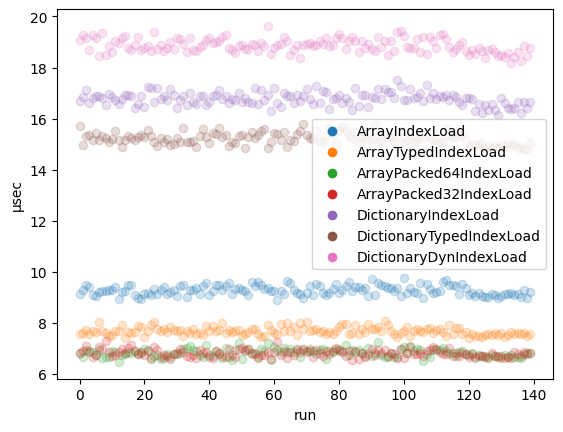

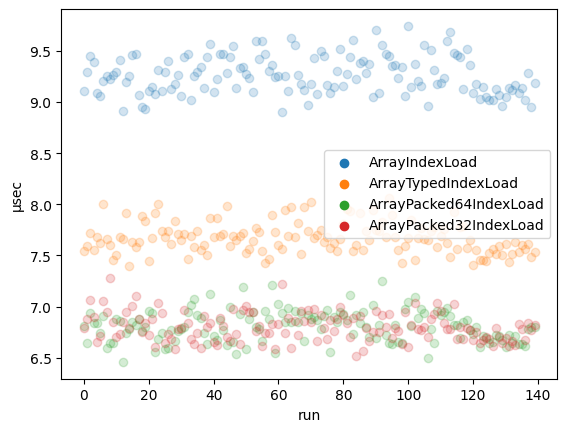

In [44]:
graph_usecs(all_measurements[DatastructBenchmarksLoad], [
	"ArrayIndexLoad", "ArrayTypedIndexLoad", "ArrayPacked64IndexLoad", "ArrayPacked32IndexLoad", "DictionaryIndexLoad", "DictionaryTypedIndexLoad", "DictionaryDynIndexLoad"
], alpha=0.2)
graph_usecs(all_measurements[DatastructBenchmarksLoad], [
	"ArrayIndexLoad", "ArrayTypedIndexLoad", "ArrayPacked64IndexLoad", "ArrayPacked32IndexLoad", 
], alpha=0.2)

Ještě srovnání pole `string`ů - packed varianta má rychlejší čtení o cca 15%, nejde tedy o kritický rozdíl.  

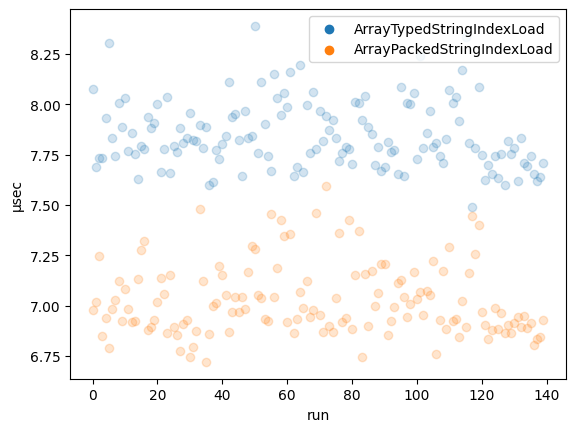

In [45]:
graph_usecs(all_measurements[DatastructBenchmarksLoad], [
	"ArrayTypedStringIndexLoad", "ArrayPackedStringIndexLoad",
], alpha=0.2)

Nyní se zaměřme na čtení z `Dictionary` vs z instance objektu.   
Pro tyto mikrobenchmarky jsme deklarovali třídu, která obsahuje instanční `int`ové proměnné pojmenované `_00`..`_49`, popř. vytvořili `Dictionary[String, int]`, který obsahuje hodnoty pod těmito stejnými klíči. V payloadu postupně čteme všechny tyto položky, s výsledkem čtení ukládaným do lokální proměnné.   

Čtení vykonáváme těmito způsoby: 
 - přímý přístup k položce (`obj._00`) (`-Named` benchmarky)
 - `operator [String]` (`-Indexer` benchmarky)
 - metoda `get(String)` (`-Get` benchmarky)

Pro `Dictionary` vidíme, že indexace je s přehledem nejrychlejší, zatímco metoda `get()` je až dvakrát pomalejší. Operátor `.` je mírně pomalejší - pravděpodobně u něj Godot nevykonává žádné základní optimalizace a platí cenu navíc za to, že musí nejdříve ověřit, že se netážeme na některou z funkcí, které typ `Dictionary` definuje. Podivné je, že u plně typované varianty výkon operátoru `.` padá hluboko pod dynamické varianty, až na úroveň volání `get()`.   
Pravděpodobně by zde mohl být potenciál pro zlepšení výkonu operátoru `.`, kdybychom ho při generování kódu uměli pomyslně přepsat na indexaci. Je však otázka, zda vůbec v praxi někdo `Dictionary` takto používá, a zda by to tedy bylo dobré využití programátorského času. 

Typicky používaný indexační operátor je nejrychlejší, a jeho rychlost roste úměrně s typovaností, což vše odpovídá intuitivnímu očekávání.   

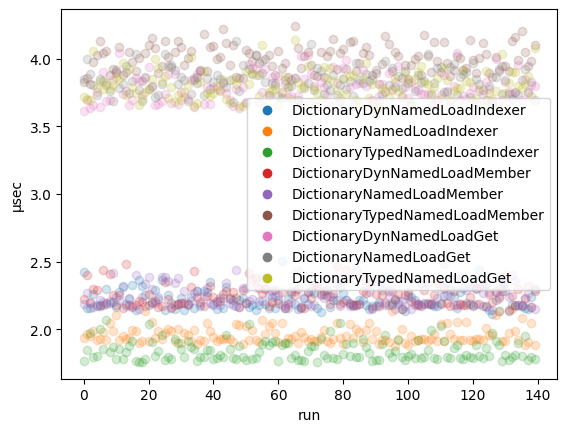

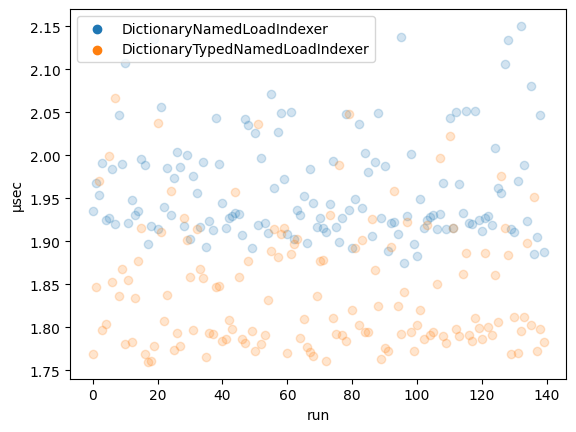

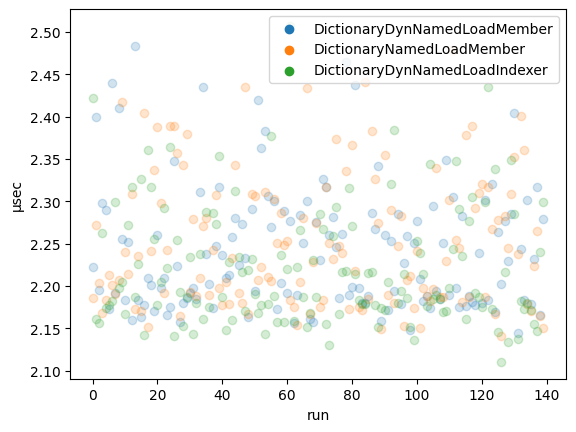

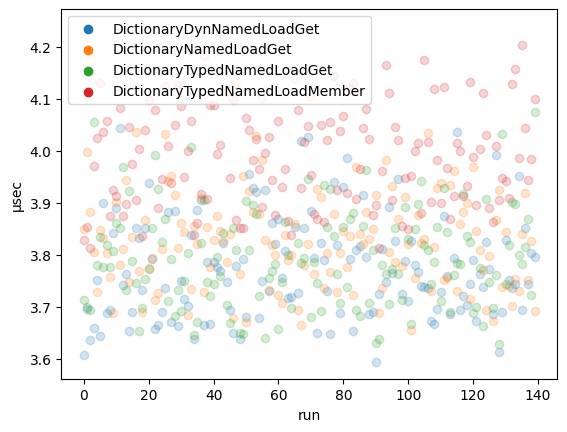

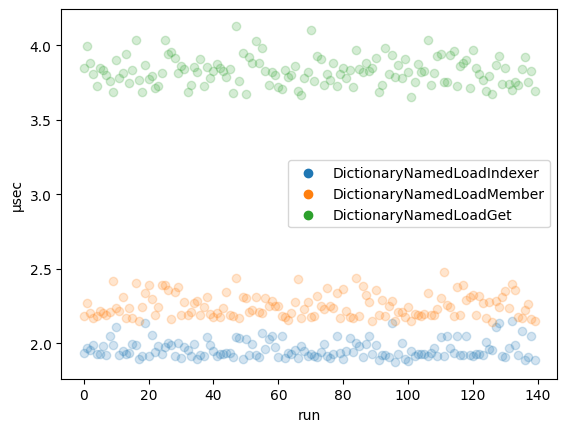

In [46]:
graph_usecs(measurements_load_fix[DatastructBenchmarksLoadFixed], [
	  "DictionaryDynNamedLoadIndexer", "DictionaryNamedLoadIndexer", "DictionaryTypedNamedLoadIndexer",
	"DictionaryDynNamedLoadMember", "DictionaryNamedLoadMember", "DictionaryTypedNamedLoadMember",
	  "DictionaryDynNamedLoadGet", "DictionaryNamedLoadGet", "DictionaryTypedNamedLoadGet",
], alpha=0.2)
graph_usecs(measurements_load_fix[DatastructBenchmarksLoadFixed], [
	   "DictionaryNamedLoadIndexer", "DictionaryTypedNamedLoadIndexer",
], alpha=0.2)
graph_usecs(measurements_load_fix[DatastructBenchmarksLoadFixed], [
	"DictionaryDynNamedLoadMember", "DictionaryNamedLoadMember","DictionaryDynNamedLoadIndexer",
], alpha=0.2)

graph_usecs(measurements_load_fix[DatastructBenchmarksLoadFixed], [
	  "DictionaryDynNamedLoadGet", "DictionaryNamedLoadGet", "DictionaryTypedNamedLoadGet", "DictionaryTypedNamedLoadMember",
], alpha=0.2)

graph_usecs(measurements_load_fix[DatastructBenchmarksLoadFixed], [
	  "DictionaryNamedLoadIndexer", "DictionaryNamedLoadMember", "DictionaryNamedLoadGet",
], alpha=0.2)

Pro objekty vidíme obdobně, že typicky používaný způsob - v tomto případě operátor `.` je nejrychlejší.   
Funkce `get()` je buď téměř stejně rychlá, nebo násobně pomalejší - dle toho, zda pracujeme s typovanou či dynamickou proměnnou.  
Indexace je cca o 50% pomalejší než přístup k fieldu a rychlost má konzistentní bez ohledu na dynamičnost.  

Funkce `get()` by v dynamické variantě zasloužila trochu optimalizační péče - v generických pomocných funkcích jde o poměrně častý obrat (a operátor `[]` kvůli drobným rozdílům v sémantice často není adekvátní náhrada).

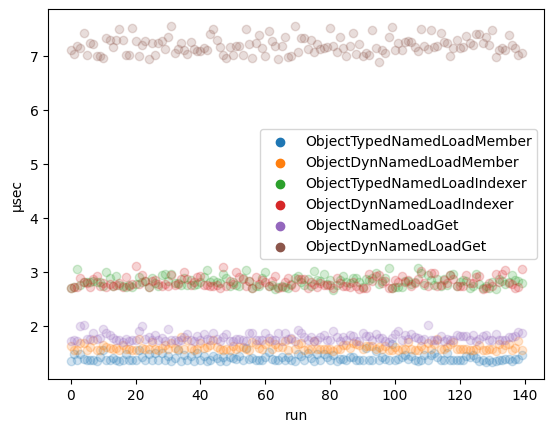

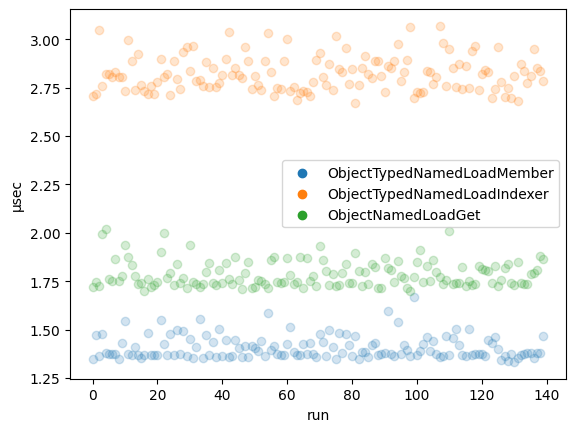

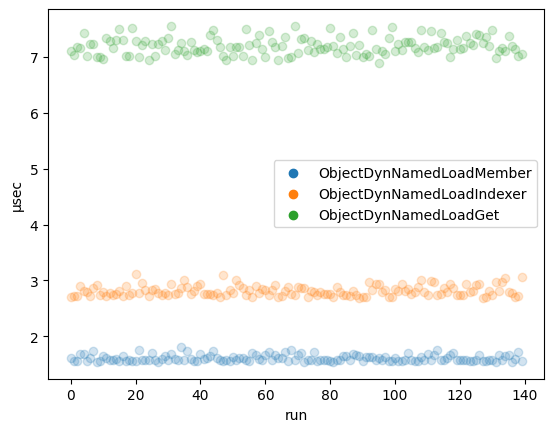

In [47]:
graph_usecs(measurements_load_fix[DatastructBenchmarksLoadFixed], [
	  "ObjectTypedNamedLoadMember", "ObjectDynNamedLoadMember", 
	"ObjectTypedNamedLoadIndexer", "ObjectDynNamedLoadIndexer", 
	  "ObjectNamedLoadGet", "ObjectDynNamedLoadGet", 
], alpha=0.2)
graph_usecs(measurements_load_fix[DatastructBenchmarksLoadFixed], [
	  "ObjectTypedNamedLoadMember", "ObjectTypedNamedLoadIndexer", "ObjectNamedLoadGet", 
], alpha=0.2)
graph_usecs(measurements_load_fix[DatastructBenchmarksLoadFixed], [
	  "ObjectDynNamedLoadMember", "ObjectDynNamedLoadIndexer", "ObjectDynNamedLoadGet", 
], alpha=0.2)


Srovnejme nyní velmi zběžně `Dictionary` a objekt.   
Vidíme, že operátor `.` na objektu je jednoznačně nejrychlejší, avšak operátor `[]` na `Dictionary` se drží v poměrně těsném závěsu.   
Všeobecně jsou rychlost čtení z objektu a z `Dictionary` na zhruba srovnatelné úrovni.    

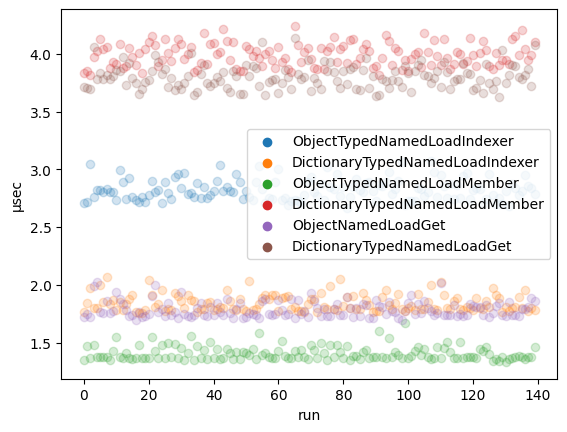

In [71]:
graph_usecs(measurements_load_fix[DatastructBenchmarksLoadFixed], [
	"ObjectTypedNamedLoadIndexer","DictionaryTypedNamedLoadIndexer",
	"ObjectTypedNamedLoadMember", "DictionaryTypedNamedLoadMember",
	"ObjectNamedLoadGet", "DictionaryTypedNamedLoadGet",
], alpha=0.2)


##### Zapisování dat
Nyní se zaměřme na přepisování dat v již alokované paměti.   
Mikrobenchmarky používají stejnou jmennou konvenci jako v předchozí sekci. Opět iterujeme přes indexy `0..500` a tentokrát zapisujeme konstantu `1`.

Vidíme, že řádově se pohybujeme v podobných časových hodnotách jako při čtení, opět je zde podobná hierarchie rychlosti, kde packed- specializace jsou s přehledem nejrychlejší, obecný `Array` je pomalejší cca o 30%, a `Dictionary` je cca dvakrát pomalejší než `Array`.    
Změna je v tom, že mezi typovanými a netypovanými variantami nyní vidíme nulový rozdíl. Znalost typu nám nedává žádnou výhodu, když tak jako tak víme, že budeme muset zapisovat plných 24 bytů. Po předchozí zkušenosti s voláním funkcí bychom mohli pesimisticky očekávat, že plně typované zápisy budou dokonce pomalejší než dynamické - je pěkné, že alespoň v tomto případě Godot neponechává na runtime checky, které lze vykonat za kompilace.   
V případné navazující práci by mohlo být zajímavé otestovat tuto situaci s ukládáním reference-countovaných objektů, v jejichž případě zápis neznamená pouze `memcpy`.    

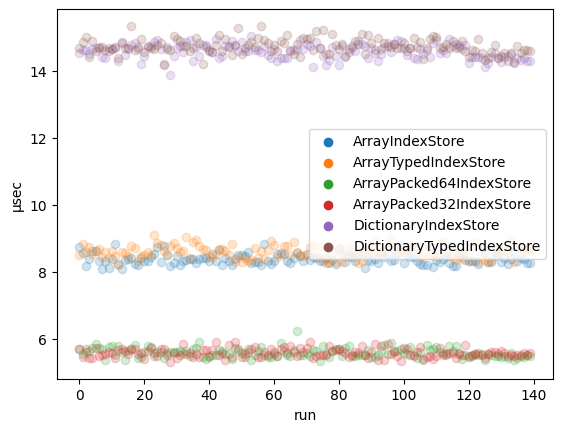

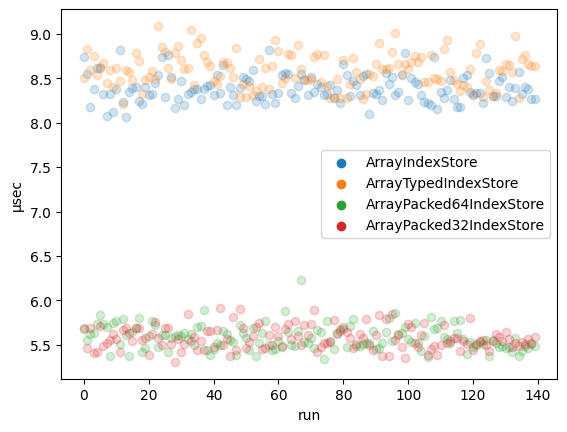

In [49]:
graph_usecs(all_measurements[DatastructBenchmarksStore], [
	"ArrayIndexStore", "ArrayTypedIndexStore", "ArrayPacked64IndexStore", "ArrayPacked32IndexStore", "DictionaryIndexStore", "DictionaryTypedIndexStore", 
], alpha=0.2)
graph_usecs(all_measurements[DatastructBenchmarksStore], [
	"ArrayIndexStore", "ArrayTypedIndexStore", "ArrayPacked64IndexStore", "ArrayPacked32IndexStore"
], alpha=0.2)

Pro zápisy vidíme u pole `String`ů mezi packed- a obecnou verzí cca 100% rozdíl, což je o dost více než při čtení. Používat specializaci se tedy přeci jen vyplatí.       

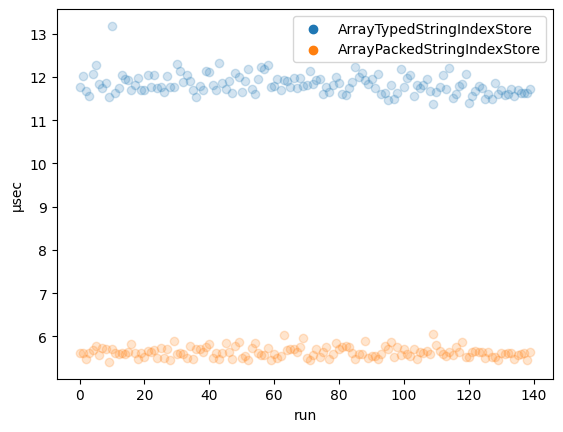

In [50]:
graph_usecs(all_measurements[DatastructBenchmarksStore], [
	"ArrayTypedStringIndexStore", "ArrayPackedStringIndexStore",
], alpha=0.2)

Stejně jako u čtení, opět je nejrychlejší indexace, následovaná v těsném závěsu operátorem `.` v dynamickém kontextu.  
Dvakrát pomalejší je funkce `get()` a operátor `.` na silně typovaném `Dictionary`.      

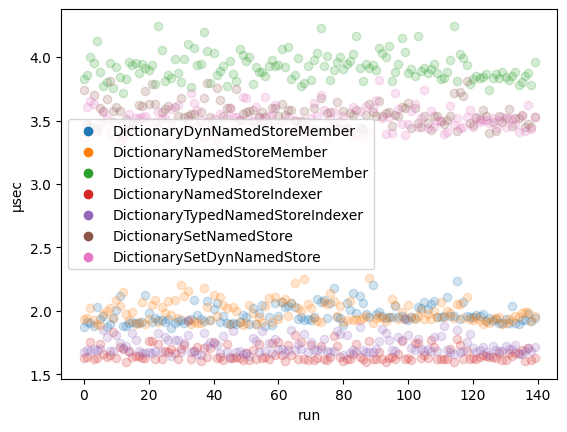

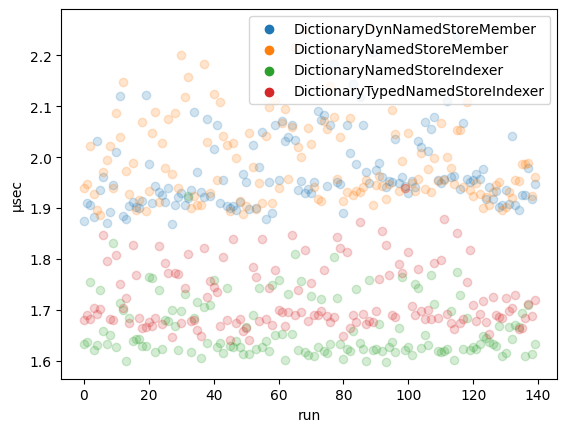

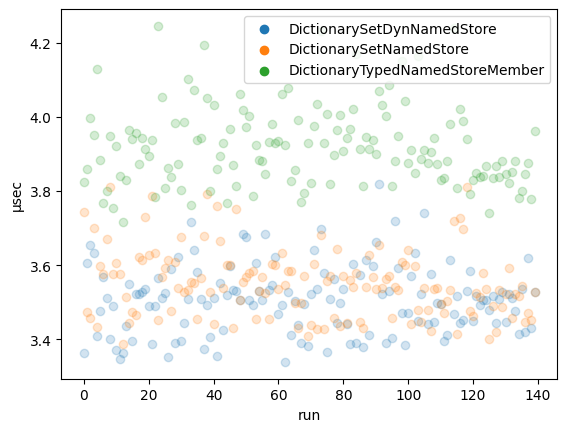

In [51]:
graph_usecs(all_measurements[DatastructBenchmarksStore], [
	"DictionaryDynNamedStoreMember", "DictionaryNamedStoreMember", "DictionaryTypedNamedStoreMember", "DictionaryNamedStoreIndexer", "DictionaryTypedNamedStoreIndexer", "DictionarySetNamedStore",  "DictionarySetDynNamedStore",
], alpha=0.2)
graph_usecs(all_measurements[DatastructBenchmarksStore], [
	"DictionaryDynNamedStoreMember", "DictionaryNamedStoreMember", "DictionaryNamedStoreIndexer", "DictionaryTypedNamedStoreIndexer", 
], alpha=0.2)

graph_usecs(all_measurements[DatastructBenchmarksStore], [
	"DictionarySetDynNamedStore", "DictionarySetNamedStore", "DictionaryTypedNamedStoreMember"
], alpha=0.2)


U objektů rovněž vše cca odpovídá stavu z předchozí sekce - dynamická funkce `set()` je několikanásobně pomalejší než vše ostatní. Přístup k fieldu je nejrychlejší, s ještě větším přehledem než při čtení.   

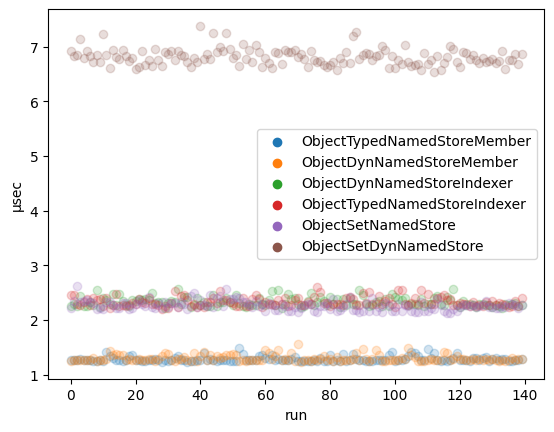

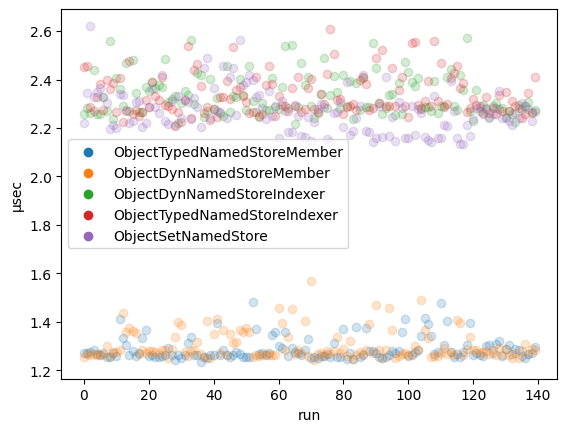

In [52]:
graph_usecs(all_measurements[DatastructBenchmarksStore], [
	"ObjectTypedNamedStoreMember", "ObjectDynNamedStoreMember", "ObjectDynNamedStoreIndexer", "ObjectTypedNamedStoreIndexer", "ObjectSetNamedStore", "ObjectSetDynNamedStore",
], alpha=0.2)
graph_usecs(all_measurements[DatastructBenchmarksStore], [
	"ObjectTypedNamedStoreMember", "ObjectDynNamedStoreMember", "ObjectDynNamedStoreIndexer", "ObjectTypedNamedStoreIndexer", "ObjectSetNamedStore",
], alpha=0.2)

#### Vytváření

Finálně se zaměřme na přidávání nových dat do datových struktur.   

Nejprve pole - tyto benchmarky sestávají z vytvoření prázdné datové struktury, do které následně přidáme 500 `int`ových položek.    

Přidávání jedna po druhé metodou `arr.append(i)` - packed-varianty jsou více než dvakrát rychlejší než generické pole. Množství alokované paměti poměrově odpovídá očekávání.   
V `Dictionary[int, int]` zkrátka zapisujeme na index `0..500`. Vidíme, že to je více než o 100% pomalejší než obecné pole (ale jak nastiňujeme výše, toto lze brát pouze orientačně).  

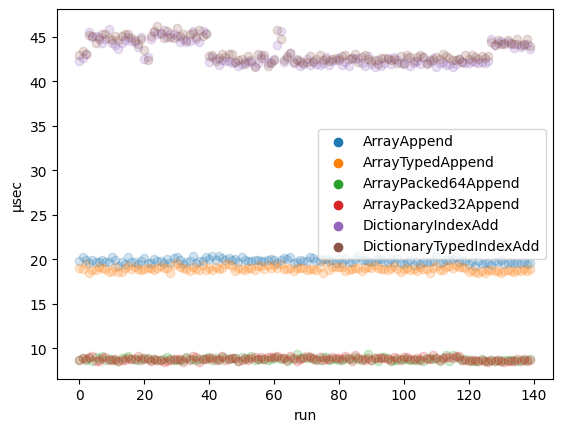

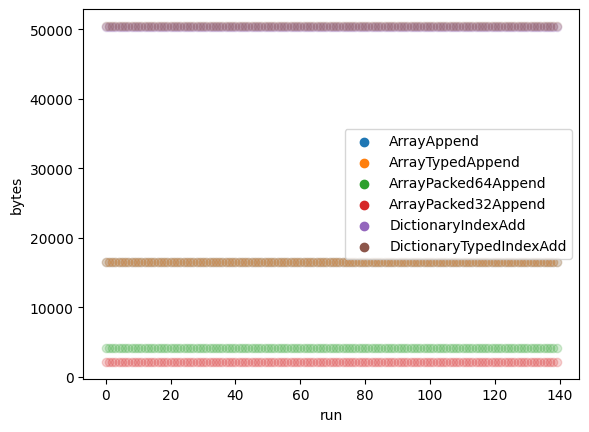

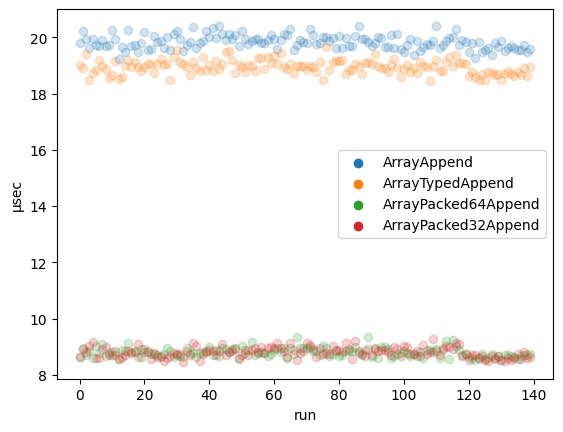

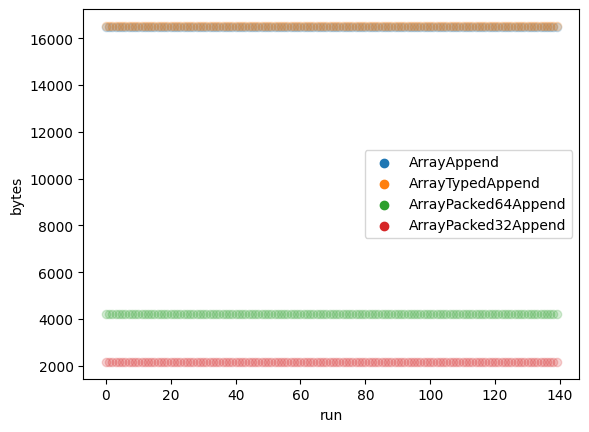

{'allocated_bytes': {'ArrayAppend': 16464,
  'ArrayTypedAppend': 16528,
  'ArrayPacked64Append': 4208,
  'ArrayPacked32Append': 2160,
  'DictionaryIndexAdd': 50352,
  'DictionaryTypedIndexAdd': 50488},
 'alloc_calls': {'ArrayAppend': 2,
  'ArrayTypedAppend': 3,
  'ArrayPacked64Append': 3,
  'ArrayPacked32Append': 3,
  'DictionaryIndexAdd': 513,
  'DictionaryTypedIndexAdd': 514},
 'realloc_calls': {'ArrayAppend': 2,
  'ArrayTypedAppend': 3,
  'ArrayPacked64Append': 3,
  'ArrayPacked32Append': 3,
  'DictionaryIndexAdd': 513,
  'DictionaryTypedIndexAdd': 514}}

In [ ]:
temp = ["ArrayAppend", "ArrayTypedAppend", "ArrayPacked64Append", "ArrayPacked32Append", "DictionaryIndexAdd", "DictionaryTypedIndexAdd"]
multigraph([all_usecs, all_alloc_bytes], all_measurements[DatastructBenchmarksCreation], temp, alpha=0.2)
multigraph([all_usecs, all_alloc_bytes], all_measurements[DatastructBenchmarksCreation], [
	"ArrayAppend", "ArrayTypedAppend", "ArrayPacked64Append", "ArrayPacked32Append"
], alpha=0.2)
allocations_preview(all_measurements[DatastructBenchmarksCreation], temp)

To samé platí i pro `String` (v tomto benchmarku přidáváme na všechny indexy již existující stringový literál, nově tedy alokujeme pouze pointery na něj).  

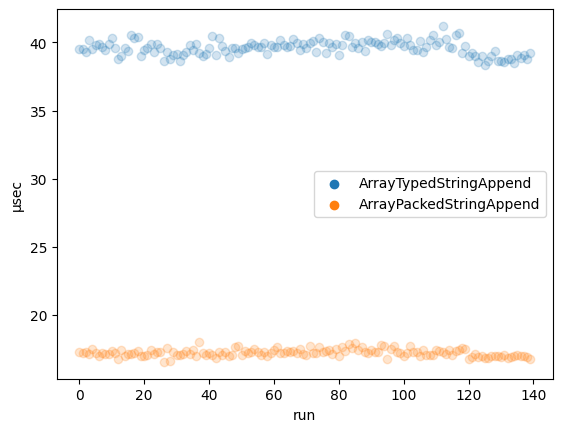

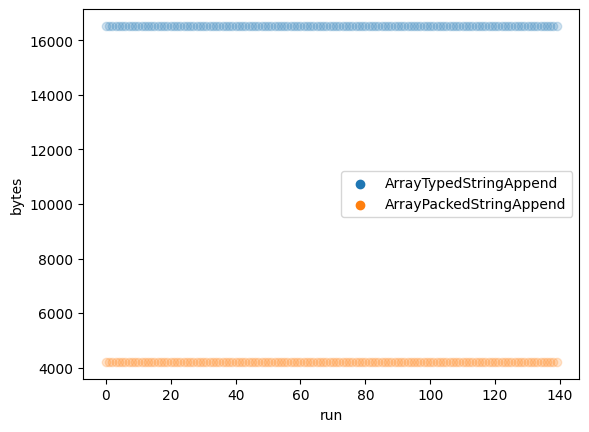

{'allocated_bytes': {'ArrayTypedStringAppend': 16528,
  'ArrayPackedStringAppend': 4208},
 'alloc_calls': {'ArrayTypedStringAppend': 3, 'ArrayPackedStringAppend': 3},
 'realloc_calls': {'ArrayTypedStringAppend': 3, 'ArrayPackedStringAppend': 3}}

In [ ]:

temp = ["ArrayTypedStringAppend","ArrayPackedStringAppend",]
multigraph([all_usecs, all_alloc_bytes], all_measurements[DatastructBenchmarksCreation], temp, alpha=0.2)
allocations_preview(all_measurements[DatastructBenchmarksCreation], temp)

V následujících benchmarcích vytvoříme prázdné pole, na něm zavoláme metodu `resize(500)` a následně ho projdeme a na každý index zapíšeme konstantní hodnotu.

S výjimkou benchmarku `ArrayRange` - v něm vytvoříme a naalokujeme pole jediným voláním `range(500)`, načež ho projdeme a na každý index zapíšeme konstantní hodnotu.   

Vidíme, že myšlenka s `range` je slepou uličkou, vytvoření a následné zavolání `resize()` je nezanedbatelně rychlejší. Packed-varianta je cca 2-krát rychlejší než obecná, množství alokované paměti odpovídá očekávání.

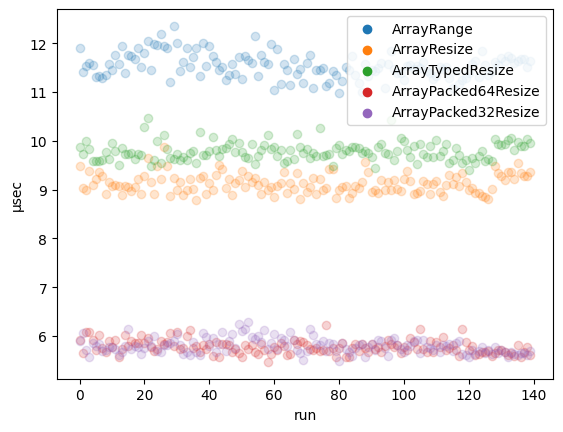

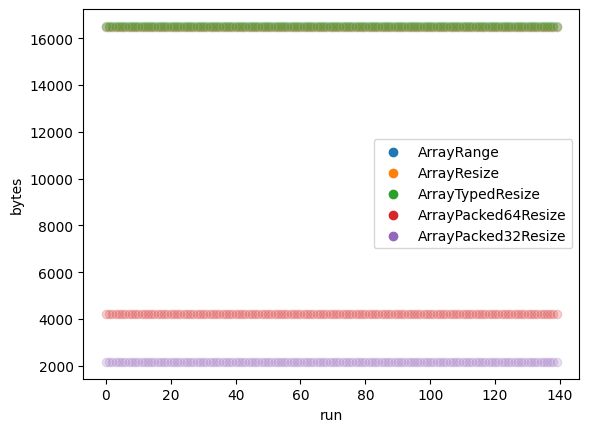

{'allocated_bytes': {'ArrayTypedStringAppend': 16528,
  'ArrayPackedStringAppend': 4208},
 'alloc_calls': {'ArrayTypedStringAppend': 3, 'ArrayPackedStringAppend': 3},
 'realloc_calls': {'ArrayTypedStringAppend': 3, 'ArrayPackedStringAppend': 3}}

In [74]:

multigraph([all_usecs, all_alloc_bytes], all_measurements[DatastructBenchmarksCreation], [
	"ArrayRange","ArrayResize","ArrayTypedResize","ArrayPacked64Resize","ArrayPacked32Resize"
], alpha=0.2)
allocations_preview(all_measurements[DatastructBenchmarksCreation], temp)


Varianta se `String`y nyní opět plně odpovídá očekávání.  

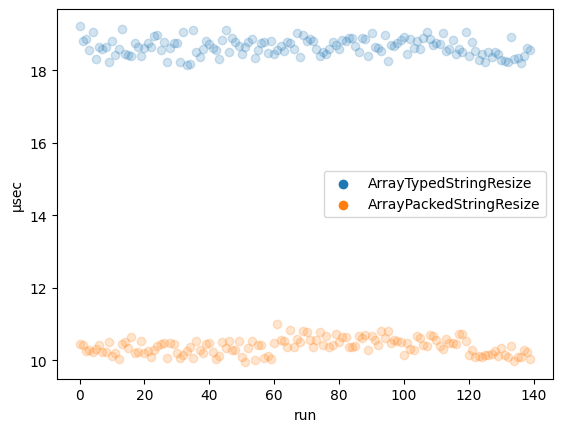

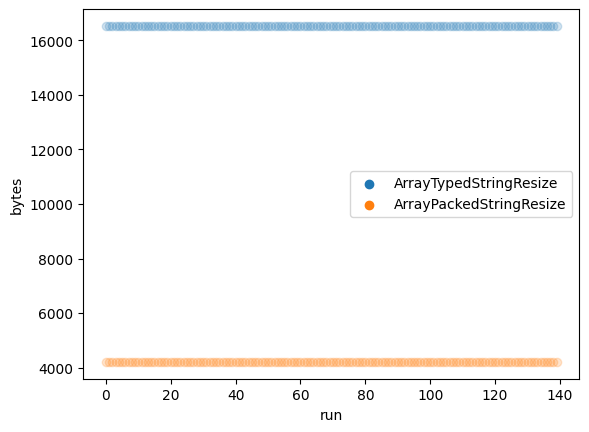

{'allocated_bytes': {'ArrayTypedStringResize': 16528,
  'ArrayPackedStringResize': 4208},
 'alloc_calls': {'ArrayTypedStringResize': 3, 'ArrayPackedStringResize': 3},
 'realloc_calls': {'ArrayTypedStringResize': 3, 'ArrayPackedStringResize': 3}}

In [76]:
temp = ["ArrayTypedStringResize", "ArrayPackedStringResize",]
multigraph([all_usecs, all_alloc_bytes], all_measurements[DatastructBenchmarksCreation], temp, alpha=0.2)
allocations_preview(all_measurements[DatastructBenchmarksCreation], temp)

Zakončeme srovnáním obou přístupů.   
S předalokováním bufferu skrze `resize()` se nám rychlost pro obecné pole zlepší téměř dvojnásobně, pro packed-variantu je zrychlení cca 50%.   
Velmi podivné je, že pro `resize()` jsme naměřili stejný objem i počet alokací jako při appendování, intuitivně by člověk očekával, že by mělo dojít k jediné alokaci a 0 voláním realloc.  

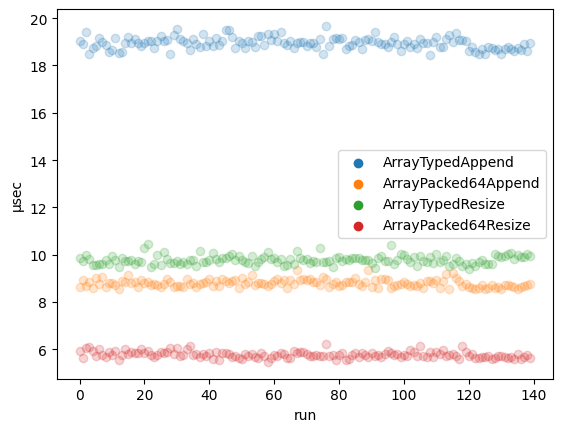

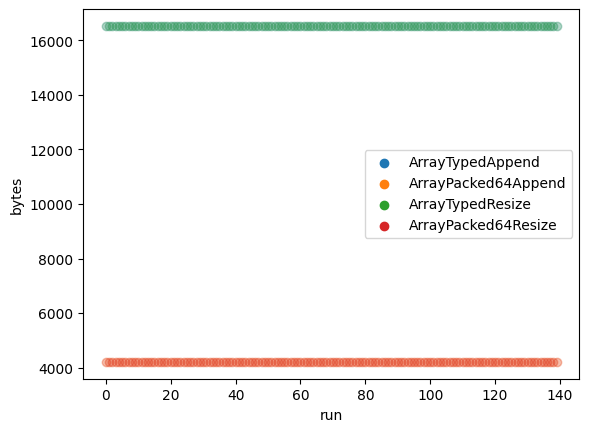

{'allocated_bytes': {'ArrayTypedAppend': 16528,
  'ArrayPacked64Append': 4208,
  'ArrayTypedResize': 16528,
  'ArrayPacked64Resize': 4208},
 'alloc_calls': {'ArrayTypedAppend': 3,
  'ArrayPacked64Append': 3,
  'ArrayTypedResize': 3,
  'ArrayPacked64Resize': 3},
 'realloc_calls': {'ArrayTypedAppend': 3,
  'ArrayPacked64Append': 3,
  'ArrayTypedResize': 3,
  'ArrayPacked64Resize': 3}}

In [82]:
temp = ["ArrayTypedAppend", "ArrayPacked64Append", "ArrayTypedResize", "ArrayPacked64Resize"]
multigraph([all_usecs, all_alloc_bytes], all_measurements[DatastructBenchmarksCreation], temp, alpha=0.2)

allocations_preview(all_measurements[DatastructBenchmarksCreation], temp)

Nyní na srovnání `Dictionary` vs objekt.   
V následujících testech jsme pokaždé vytvořili prázdnou instanci `Dictionary`/objektu a následně na indexy `_00`..`_49` zapsali číselnou konstantu.   

Z hlediska času zde platí to samé jako v předchozích sekcích - indexační operátor je nejrychlejší, `set()` a operátor `.` specificky v silně typované situaci, jsou nejpomalejší.   

Všechny varianty alokovaly paměť téměř identicky.   

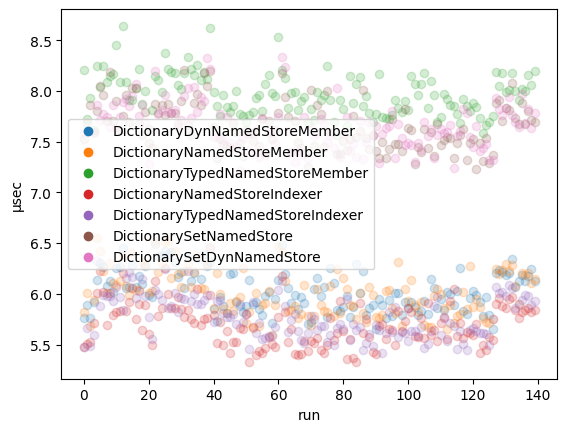

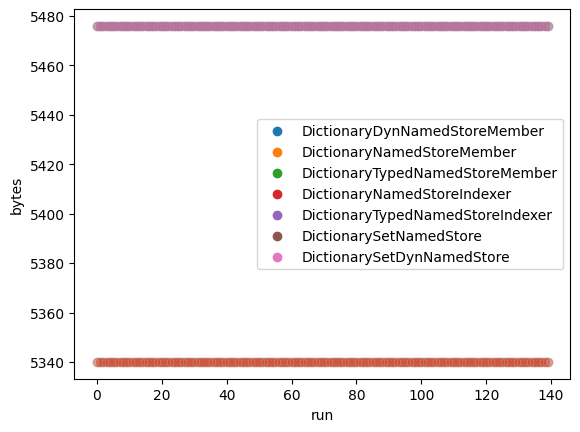

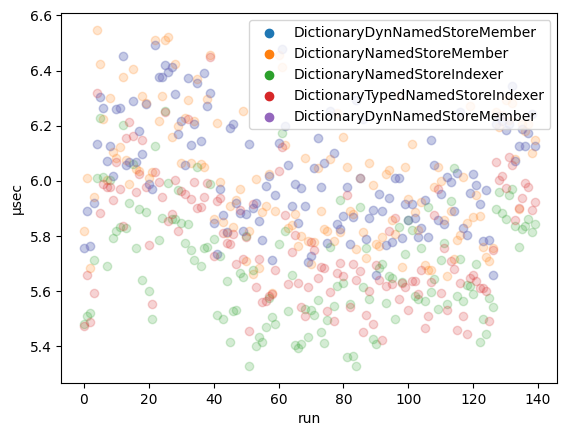

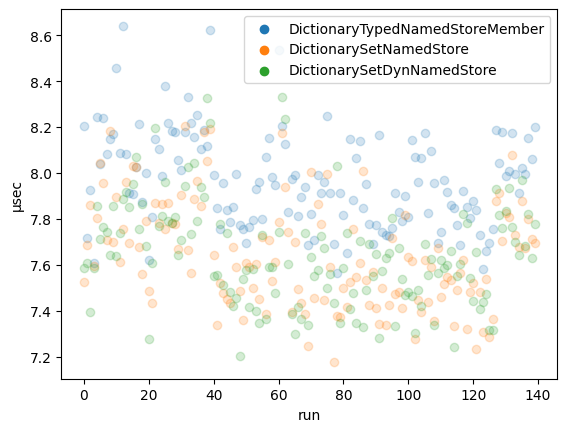

{'allocated_bytes': {'DictionaryDynNamedStoreMember': 5340,
  'DictionaryNamedStoreMember': 5340,
  'DictionaryTypedNamedStoreMember': 5476,
  'DictionaryNamedStoreIndexer': 5340,
  'DictionaryTypedNamedStoreIndexer': 5476,
  'DictionarySetNamedStore': 5476,
  'DictionarySetDynNamedStore': 5476},
 'alloc_calls': {'DictionaryDynNamedStoreMember': 57,
  'DictionaryNamedStoreMember': 57,
  'DictionaryTypedNamedStoreMember': 58,
  'DictionaryNamedStoreIndexer': 57,
  'DictionaryTypedNamedStoreIndexer': 58,
  'DictionarySetNamedStore': 58,
  'DictionarySetDynNamedStore': 58},
 'realloc_calls': {'DictionaryDynNamedStoreMember': 57,
  'DictionaryNamedStoreMember': 57,
  'DictionaryTypedNamedStoreMember': 58,
  'DictionaryNamedStoreIndexer': 57,
  'DictionaryTypedNamedStoreIndexer': 58,
  'DictionarySetNamedStore': 58,
  'DictionarySetDynNamedStore': 58}}

In [88]:
temp = [
	"DictionaryDynNamedStoreMember","DictionaryNamedStoreMember","DictionaryTypedNamedStoreMember","DictionaryNamedStoreIndexer","DictionaryTypedNamedStoreIndexer","DictionarySetNamedStore","DictionarySetDynNamedStore",
]
multigraph([all_usecs, all_alloc_bytes], all_measurements[DatastructBenchmarksCreation], temp, alpha=0.2)

multigraph([all_usecs], all_measurements[DatastructBenchmarksCreation], [
	"DictionaryDynNamedStoreMember","DictionaryNamedStoreMember", "DictionaryNamedStoreIndexer", "DictionaryTypedNamedStoreIndexer", "DictionaryDynNamedStoreMember",
], alpha=0.2)

multigraph([all_usecs], all_measurements[DatastructBenchmarksCreation], [
	"DictionaryTypedNamedStoreMember","DictionarySetNamedStore","DictionarySetDynNamedStore",
], alpha=0.2)

allocations_preview(all_measurements[DatastructBenchmarksCreation], temp)

Pro objekt zde rovněž potvrdíme předchozí pozorování - operátor `.` je nejrychlejší; funkce `set()` v dynamickém kontextu je cca dvakrát pomalejší než ostatní varianty.

Všechny payloady alokují identicky.      

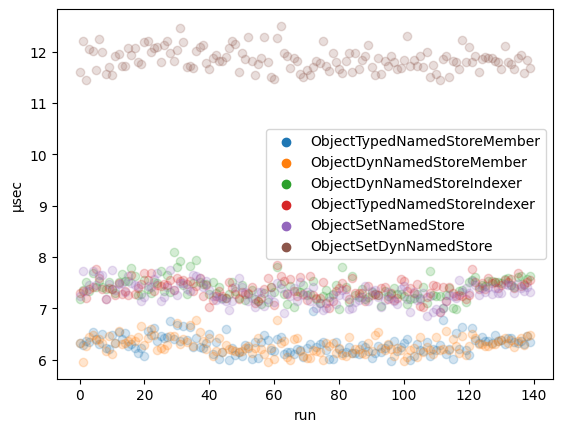

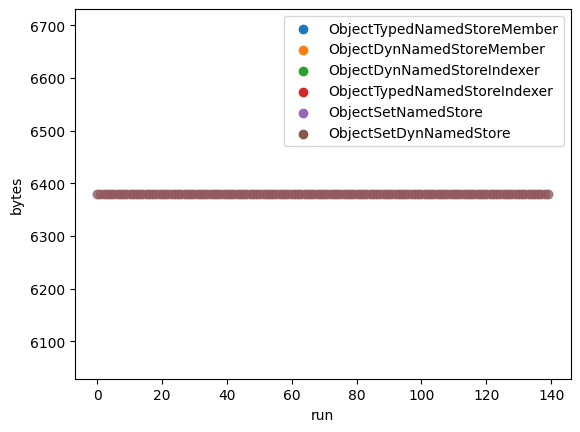

{'allocated_bytes': {'ObjectTypedNamedStoreMember': 6380,
  'ObjectDynNamedStoreMember': 6380,
  'ObjectDynNamedStoreIndexer': 6380,
  'ObjectTypedNamedStoreIndexer': 6380,
  'ObjectSetNamedStore': 6380,
  'ObjectSetDynNamedStore': 6380},
 'alloc_calls': {'ObjectTypedNamedStoreMember': 64,
  'ObjectDynNamedStoreMember': 64,
  'ObjectDynNamedStoreIndexer': 64,
  'ObjectTypedNamedStoreIndexer': 64,
  'ObjectSetNamedStore': 64,
  'ObjectSetDynNamedStore': 64},
 'realloc_calls': {'ObjectTypedNamedStoreMember': 64,
  'ObjectDynNamedStoreMember': 64,
  'ObjectDynNamedStoreIndexer': 64,
  'ObjectTypedNamedStoreIndexer': 64,
  'ObjectSetNamedStore': 64,
  'ObjectSetDynNamedStore': 64}}

In [89]:
temp = [
	"ObjectTypedNamedStoreMember","ObjectDynNamedStoreMember","ObjectDynNamedStoreIndexer","ObjectTypedNamedStoreIndexer","ObjectSetNamedStore","ObjectSetDynNamedStore"
]
multigraph([all_usecs, all_alloc_bytes], all_measurements[DatastructBenchmarksCreation], temp, alpha=0.2)

allocations_preview(all_measurements[DatastructBenchmarksCreation], temp)

Při zahrnování alokace je objekt nepatrně pomalejší než `Dictionary`.  
Objekt alokuje více dat, což dává smysl - musí nést dodatečná data pro účely reflexe apod. .
Podivný však je jeho počet alokací, který je dokonce vyšší než u `Dictionary`, ačkoliv bychom intuitivně očekávali, že se naalokuje celý najednou v okamžiku volání `Type.new()` 

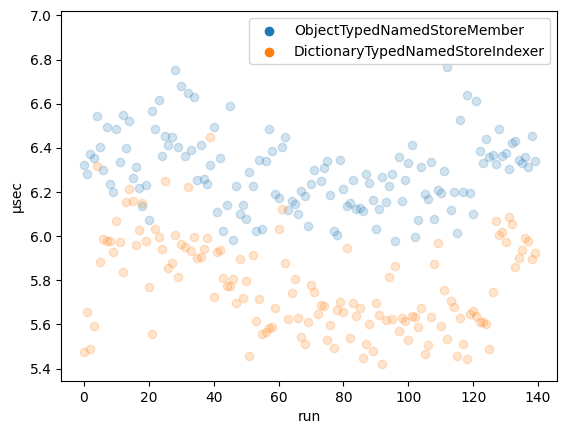

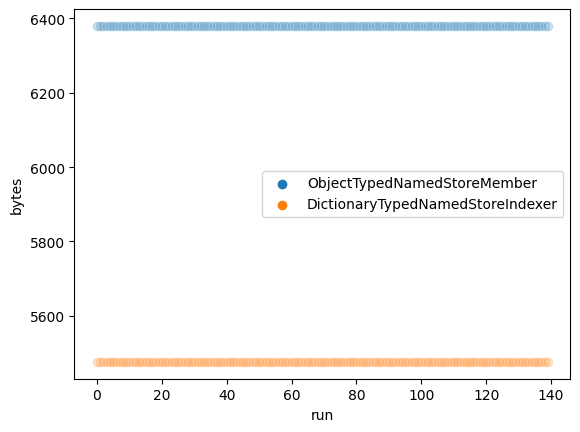

{'allocated_bytes': {'ObjectTypedNamedStoreMember': 6380,
  'DictionaryTypedNamedStoreIndexer': 5476},
 'alloc_calls': {'ObjectTypedNamedStoreMember': 64,
  'DictionaryTypedNamedStoreIndexer': 58},
 'realloc_calls': {'ObjectTypedNamedStoreMember': 64,
  'DictionaryTypedNamedStoreIndexer': 58}}

In [90]:
temp = [
	"ObjectTypedNamedStoreMember","DictionaryTypedNamedStoreIndexer",
]
multigraph([all_usecs, all_alloc_bytes], all_measurements[DatastructBenchmarksCreation], temp, alpha=0.2)

allocations_preview(all_measurements[DatastructBenchmarksCreation], temp)

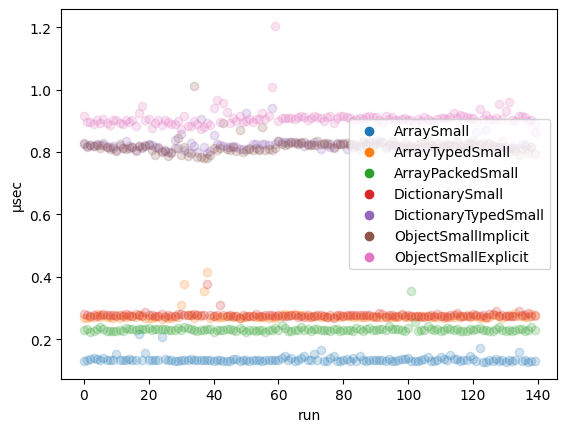

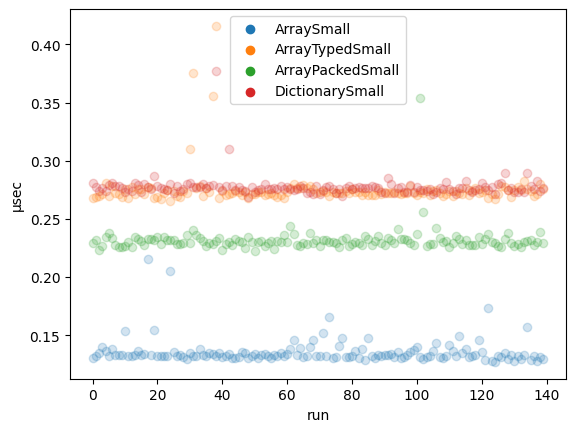

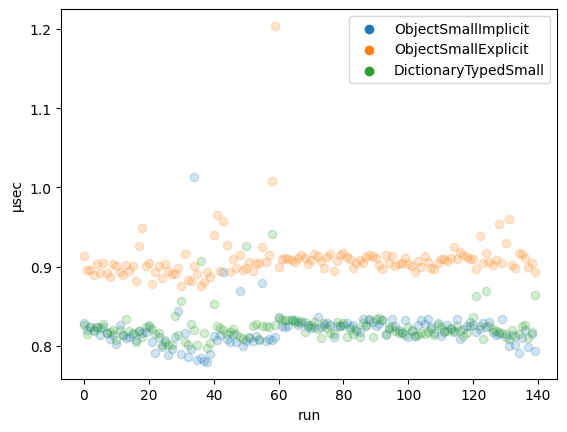

{'allocated_bytes': {'ArraySmall': 208,
  'ArrayTypedSmall': 416,
  'ArrayPackedSmall': 288,
  'DictionarySmall': 540,
  'DictionaryTypedSmall': 1428,
  'ObjectSmallImplicit': 1132,
  'ObjectSmallExplicit': 1132},
 'alloc_calls': {'ArraySmall': 2,
  'ArrayTypedSmall': 4,
  'ArrayPackedSmall': 4,
  'DictionarySmall': 5,
  'DictionaryTypedSmall': 16,
  'ObjectSmallImplicit': 12,
  'ObjectSmallExplicit': 12},
 'realloc_calls': {'ArraySmall': 2,
  'ArrayTypedSmall': 4,
  'ArrayPackedSmall': 4,
  'DictionarySmall': 5,
  'DictionaryTypedSmall': 16,
  'ObjectSmallImplicit': 12,
  'ObjectSmallExplicit': 12}}

In [93]:
temp = [
	"ArraySmall","ArrayTypedSmall","ArrayPackedSmall","DictionarySmall","DictionaryTypedSmall","ObjectSmallImplicit","ObjectSmallExplicit"
]
multigraph([all_usecs], all_measurements[DatastructBenchmarksCreation], temp, alpha=0.2)

multigraph([all_usecs], all_measurements[DatastructBenchmarksCreation], ["ArraySmall","ArrayTypedSmall","ArrayPackedSmall","DictionarySmall"], alpha=0.2)
multigraph([all_usecs], all_measurements[DatastructBenchmarksCreation], ["ObjectSmallImplicit","ObjectSmallExplicit","DictionaryTypedSmall",], alpha=0.2)

allocations_preview(all_measurements[DatastructBenchmarksCreation], temp)

----------------------------------------------

#### Úpravy Godotu

K uskutečnění našeho experimentu bylo třeba vykonat několik drobných úprav ve zdrojovém kódu Godotu.

> Všechny přidané nativní funkce jsme pro jednoduchost nabindovali do statické třídy `OS`. Bindovací kód lze nalézet v [`core_bind.cpp`](https://github.com/MarkusSecundus/NSWI131-Credit-GDScriptPerformanceEvaluation/blob/godot-fork/core/core_bind.cpp).

##### Sledování dynamických alokací
Ideálně bychom chtěli být schopni sledovat pouze alokace, které nastaly následkem běhu našich mikrobenchmarků a nezapočítat např. ty, které vykonal fyzikální subsystém běžící na vedlejším threadu apod. .   
K našemu štěstí, Godot téměř nikde nepoužívá napřímo `malloc`, ani dynamicky alokující `operator new()` - k alokacím na haldě slouží téměř výhradně funkce `(alloc|realloc|free)_static` nacházející se v headeru [memory.h](https://github.com/godotengine/godot/blob/master/core/os/memory.h). Přímo `malloc()` používá několik méně důležitých knihoven, plus existuje `alloc_aligned_static()`, který je však použitý pouze kdesi v hlubinách grafické pipeline a fyzikálního systému.   
`alloc_static()` interně volá systémový `malloc()` a kolem něj provádí další logiku - mimo jiné i velmi základní sledování kolik paměti je aktuálně alokováno (celkový počet alokovaných bytů je jediná informace kterou udržuje - pro naše účely nedostatečné) - alokované bloky jsou opatřeny 16B prepadingem, který v sobě nese mimo jiné velikost alokovaného bloku, kterou lze následně přečíst v `realloc_static`/`free_static` (toto se ifdefem vypíná ve finálním exportu hry).    

Náš dodatek vypadá takto: 
- z Godotu se kolem běhu benchmarku volá dvojice funkcí `OS.start_tracking_memory()`, `OS.stop_tracking_memory()`   
- `start_tracking_memory()` nastaví flag a vynuluje `thread_local` počítadla pro počet alokací/realokací/alokovaných bytů/apod.   
- V alokačních funkcích je přidána logika, která podmíněně flagem inkrementuje příslušná počítadla     
- Pro počítadla jsme přidali getter funkce, kterými je možné jejich hodnotu přečíst z GDScriptu   

Takto vyfiltrujeme údaje o alokacích vykonané pouze threadem, na kterém běží interpreter. Žádné z našich microbenchmarků neobsahují nic, co by byť vzdáleně zavánělo multithreadingem, pro naše účely jde tedy o vhodné řešení.         
Zběžným pohledem by výkonový overhead neměl být značný - jde pouze o dobře předvídatelný podmíněný skok a několik přičítání nad `thread_local` proměnnými, `alloc_static` v defaultu obsahuje i složitější logiku.    
Funkce `*alloc_static_aligned()` jsme se rozhodli netrackovat, Godot sám je do svého standardního trackování paměti nezahrnuje, to samé platí pro explicitní volání malloc v knihovnách.   

##### Disassembler
Godotí codebase obsahuje disassembler interního bytokódu v [`gdscript_disassembler.cpp`](https://github.com/godotengine/godot/blob/master/modules/gdscript/gdscript_disassembler.cpp), je však používaný pouze interně kdesi v unit testech. Pro naše účely bylo nutné vytvořit lehký wrapper, přes který jsme funkcionalitu exposovali do GDScriptu. Implementace disassembleru je zahardcodovaná k vypisování výstupu vždy do konzole, což není ideální, ale pro naše akutní účely to bylo dostatečně.


##### Ostatní
Rovněž jsme přidali několik velmi jednoduchých metod sloužících k tomu, aby byly volány z mikrobenchmarků (viz sekce o volání funkcí).   





---------------------------------------------------------------

#### Chyby, které bych napravil kdybych měl více času
 - Použité CPU má 2 typy jader - P(erformance) a E(ffective). Při běhu benchmarků jsem nedal pozor, aby byla E-jádra vypnutá (buildování Godotu je bez nich více než 2x pomalejší), je tedy těžké říct, na kterém typu jádra benchmarky běžely. Víceméně se z relativní stability testů zdá, že aspoň OS většinu času byl poměrně konzistentní v tom, na který typ jádra je přiřadil, ale ideální to není. Přehazování mezi typy jader by mohlo být jedním z vysvětlení pro celkem velkou četnost outlierů, kteří se v měřeních objevovali.   
 - Bylo by asi vhodné exaktněji změřit, zda 50-krát copypaste skutečně je optimální a neústí např. ve vyhazování dat nad kterými pracujeme či pomocných dat intepreteru z L1 apod. . 